# 🛫 Projeto – Modelagem Estatística (2º Bimestre)
## Predição e Classificação de Atrasos em Voos (US Flights)

**Curso:** Ciência da Computação  
**Disciplina:** Modelagem Estatística  
**Alunos:** *Tiago Ferreira Da Silva e João Dário Pamplona Arruda*  
**Professor:** Pedro Henrique Sales Girotto  

---

# 🎯 1. Introdução

O objetivo deste projeto é analisar um conjunto de dados de voos dos Estados Unidos e desenvolver modelos de **regressão** e **classificação** capazes de:

1. **Predizer o atraso de chegada (em minutos)** de um voo (problema de regressão);
2. **Classificar se um voo atrasa ou não além de 15 minutos** (problema de classificação binária).

Do ponto de vista de negócio, esse tipo de modelo pode apoiar:

- Planejamento de malha aérea;
- Comunicação proativa com passageiros;
- Mitigação de risco operacional (janelas de conexão, alocação de portões, etc.).

### Hipóteses de negócio

1. Voos com **partida no final do dia** têm maior probabilidade de atraso.
2. Companhias aéreas possuem **padrões de atraso diferentes** entre si.
3. Voos **mais longos (DISTANCE)** tendem a ter maior atraso médio.

### Variável-alvo

- **Regressão:** `ARRIVAL_DELAY` (atraso em minutos na chegada);
- **Classificação:** `IS_DELAYED` (0 = não atrasado / 1 = atrasado mais de 15 minutos).

---

## 📂 2. Fonte e Licença do Dataset

Os dados utilizados neste projeto foram obtidos através da plataforma **Kaggle** (https://www.kaggle.com/datasets/usdot/flight-delays), que disponibiliza uma versão organizada do dataset oficial do **Bureau of Transportation Statistics (BTS)**. O **BTS** é a fonte primária dos dados originais, disponibilizados sob domínio público pelo **U.S. Department of Transportation**. O **Kaggle** atua apenas como repositório secundário para facilitar acesso e manipulação.

- **Fonte oficial:** https://www.transtats.bts.gov  
- **Link do Kaggle:** https://www.kaggle.com/datasets/usdot/flight-delays
- **Base típica utilizada:** On-Time Performance Dataset  
- **Responsável:** U.S. Department of Transportation  
- **Licença:** Dados públicos disponibilizados pelo governo federal dos EUA, regidos por *Public Domain* conforme 17 U.S.C. § 105.

### Estrutura resumida do dataset

Principais variáveis empregadas no projeto:

- `ARRIVAL_DELAY`: atraso na chegada (minutos) → variável-alvo para regressão  
- `IS_DELAYED`: atraso binário (> 15 min) → variável-alvo para classificação  
- `DISTANCE`: distância do voo (milhas)  
- `AIR_TIME`: tempo de voo (minutos)  
- `SCHEDULED_DEPARTURE`: horário programado de partida  
- `AIRLINE`: companhia aérea  

# Importação das Bibliotecas Necessárias

Nesta célula, importamos todas as bibliotecas fundamentais para a execução do projeto.  
Ela não produz saídas diretas, mas habilita todo o ecossistema necessário para:

- análise exploratória (EDA)  
- estatística inferencial  
- modelagem preditiva  
- avaliação de desempenho  
- visualizações  
- otimização de modelos  

---

## Manipulação e Análise de Dados
- **pandas**: manipulação e tratamento dos dados tabulares  
- **numpy**: operações matemáticas e vetorização  
- **seaborn** e **matplotlib**: gráficos, visualizações e apoio à EDA  

---

## Estatística e Testes
- **scipy.stats**: testes como ANOVA, teste t, Shapiro–Wilk, qui-quadrado  
- **statsmodels.api**: regressão estatística e análise de resíduos  
- **variance_inflation_factor (VIF)**: diagnóstico de multicolinearidade  
- **het_breuschpagan**: teste de homocedasticidade dos resíduos  

---

## Machine Learning (scikit-learn)
Utilizado para regressão, classificação, validação e tuning:

- Divisão **treino/teste**  
- Pré-processamento (StandardScaler, PolynomialFeatures)  
- Modelos: Linear Regression, Logistic Regression, Naive Bayes, Decision Tree, KNN  
- Métricas: MAE, RMSE, R², accuracy, precision, recall, F1, ROC-AUC  
- Técnicas de **cross-validation** e **GridSearchCV**  

---

## Configuração Visual
- Ajuste de estilo padrão para gráficos  
- Facilita consistência visual em todas as figuras do notebook  

---

## Resultado da Execução
Após executar esta célula:

- Todos os pacotes necessários estarão carregados  
- As etapas de análise, modelagem e otimização passam a estar disponíveis  
- O notebook poderá ser executado integralmente, sem erros de importação

In [68]:
# ======== IMPORTS ========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway, ttest_ind, chi2_contingency, shapiro
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve,
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# Carregando o Dataset

Nesta célula realizamos a leitura do arquivo **`flights.csv`**, que contém mais de **5,8 milhões de registros** de voos domésticos dos Estados Unidos.  
Esse dataset é a base de todo o projeto, e sua correta importação é essencial para a execução das etapas seguintes.

O objetivo desta célula é:

- carregar os dados em um `DataFrame` do pandas;  
- inspecionar sua estrutura geral;  
- validar tipos, colunas e quantidades;  
- obter estatísticas descritivas iniciais;  
- garantir que o dataset está íntegro antes de prosseguir com EDA e modelagem.

---

## Resultados obtidos após a execução

### **1. Dimensões do dataset**
Dimensões do dataset: (5819079, 31)
Isso indica que:

- existem **5.819.079 linhas** (voos individuais),  
- e **31 colunas** (variáveis informativas).  

É um dataset **grande e realista**, comum em análises de transporte aéreo.

---

### **2. Primeiras linhas do DataFrame**

A pré-visualização das 5 primeiras linhas permite:

- compreender a estrutura das variáveis;  
- confirmar que o arquivo foi importado corretamente;  
- verificar formatos como horários, códigos de aeroportos e números de voo.

Exemplos de colunas visualizadas:
- `YEAR`, `MONTH`, `DAY`  
- `AIRLINE`, `FLIGHT_NUMBER`, `TAIL_NUMBER`  
- `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT`  
- `SCHEDULED_DEPARTURE`, `ARRIVAL_TIME`  
- `ARRIVAL_DELAY`, `CANCELLED`, `WEATHER_DELAY`

---

### **3. Informação geral (`df.info()`)**

Esse resultado mostra:

- o tipo (`int64`, `float64`, `object`) de cada coluna;  
- quantos valores não nulos cada variável possui;  
- detecção inicial de dados ausentes;  
- o tamanho aproximado em memória (**~1,3 GB** carregados no notebook).

A partir disso, já podemos identificar que:

- várias colunas contêm valores `NaN` (por exemplo, atrasos específicos);  
- colunas como `AIRLINE` e aeroportos são categóricas (`object`);  
- há grande volume de dados numéricos, importante para modelagem.

---

### **4. Estatísticas descritivas (`df.describe()`)**

Inclui medidas como:

- média, mediana, desvio padrão;  
- valores mínimos e máximos;  
- quartis (Q1, Q2, Q3);  
- contagem válida por coluna.

Essas estatísticas ajudam a:

- detectar possíveis **outliers** (ex.: `ARRIVAL_DELAY` chegando a 1971 minutos);  
- entender a distribuição das variáveis;  
- observar inconsistências (como tempos negativos de atraso);  
- preparar o terreno para a EDA mais profunda.

In [69]:
# ======== CARREGANDO O DATASET ========

flights = pd.read_csv("flights.csv")

print("Dimensões do dataset:", flights.shape)
display(flights.head())

print("\nInformação geral:")
display(flights.info())

print("\nEstatísticas descritivas das colunas numéricas:")
display(flights.describe())

C:\Users\João Dário\AppData\Local\Temp\ipykernel_20964\3301196099.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv("flights.csv")


Dimensões do dataset: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



Informação geral:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED     

None


Estatísticas descritivas das colunas numéricas:


,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.732926e+06,5.730032e+06,5.730032e+06,...,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,1.329602e+03,1.335204e+03,9.370158e+00,1.607166e+01,1.357171e+03,...,1.493808e+03,1.476491e+03,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,4.837518e+02,4.964233e+02,3.708094e+01,8.895574e+00,4.980094e+02,...,5.071647e+02,5.263197e+02,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,1.110000e+03,1.059000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,...,1.520000e+03,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,...,1.918000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


# 🧹 3. Preparação de Dados

Após carregar o dataset bruto, realizamos nesta célula a etapa de **pré-processamento**, essencial para garantir a qualidade das análises estatísticas e dos modelos preditivos.  
O dataset original contém mais de 5,8 milhões de registros e diversas inconsistências naturais de dados do mundo real — por isso, o pré-processamento desempenha papel fundamental.

Esta célula executa as seguintes operações:

---

## 📌 1. Criação de uma cópia de trabalho
df = flights.copy()
Garantimos que o dataset original permanece intacto, permitindo auditoria e reprodutibilidade.



## 2. Remoção de registros sem atraso de chegada (ARRIVAL_DELAY)
df = df.dropna(subset=["ARRIVAL_DELAY"])
A modelagem depende dessa variável como alvo (regressão e classificação).
Registros sem atraso não contribuem e poderiam comprometer estatísticas e modelagem.

## 3. Criação da variável-alvo de classificação (IS_DELAYED)
df["IS_DELAYED"] = (df["ARRIVAL_DELAY"] > 15).astype(int)
Classifica voos como 1 = atrasado, 0 = não atrasado.

Limite de 15 minutos segue padrão da indústria aeronáutica.

Essa variável será usada nos modelos de classificação (Naive Bayes, Logística, etc.).

## 4. Extração da hora de partida (DEP_HOUR)
df["DEP_HOUR"] = df["SCHEDULED_DEPARTURE"].astype(str).str.zfill(4).str[:2].astype(int)
De SCHEDULED_DEPARTURE (ex.: 850 → 08h50) extraímos apenas a hora:

Facilita análises sobre comportamento por turno.

Reduz granularidade desnecessária.

Melhora interpretação nos modelos.

## 5. Tratamento de valores ausentes
Selecionamos as colunas numéricas e substituímos valores ausentes pela mediana da variável:

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

Motivos para usar mediana:
- É robusta contra outliers
- Mantém a distribuição central da variável
- Ideal para datasets com grande assimetria (como atrasos)

In [70]:
# ======== 3. PREPARAÇÃO DE DADOS ========

df = flights.copy()

# Mantemos apenas linhas com atraso de chegada não nulo
df = df.dropna(subset=["ARRIVAL_DELAY"])

# Criamos variável binária de atraso significativo (> 15 minutos)
df["IS_DELAYED"] = (df["ARRIVAL_DELAY"] > 15).astype(int)

# Extraímos hora da partida a partir de SCHEDULED_DEPARTURE (ex.: 1345 -> 13h)
df["DEP_HOUR"] = df["SCHEDULED_DEPARTURE"].astype(str).str.zfill(4).str[:2].astype(int)

# Tratamento de valores ausentes numéricos com mediana
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print("Colunas após preparação:")
print(df.columns.tolist())
display(df.head())

Colunas após preparação:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'IS_DELAYED', 'DEP_HOUR']


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IS_DELAYED,DEP_HOUR
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0


# 4. Detecção e Tratamento de Outliers (IQR)

A presença de **outliers** é comum em dados de atrasos de voos, pois eventos como mau tempo, manutenção inesperada ou congestionamento aeroportuário podem gerar valores muito acima do esperado. Esses extremos podem distorcer gráficos, testes estatísticos e modelos de regressão.

Para lidar com isso, utilizamos o método **IQR (Interquartile Range)** — uma técnica robusta e amplamente usada para tratar outliers em distribuições assimétricas, como é o caso de `ARRIVAL_DELAY`.

---
## Como o método IQR funciona

1. Calcula-se **Q1 (25%)** e **Q3 (75%)**  
2. Determina-se o intervalo interquartil:  
   \[
   IQR = Q3 - Q1
   \]
3. Define-se os limites considerados aceitáveis:
   - **Limite inferior:** Q1 − 1.5 × IQR  
   - **Limite superior:** Q3 + 1.5 × IQR  

4. Registros de `ARRIVAL_DELAY` que ultrapassam esses limites são removidos.

Esse método é apropriado para distribuições **não normais** e reduz o impacto de valores muito extremos.

---

## Resultados Obtidos

### **Faixa de atraso considerada aceitável**
**−44.50 a 39.50 minutos**

Esses limites foram calculados diretamente da distribuição real dos dados.

### **Quantidade de registros antes e depois**
- **Antes:** 5.714.008 registros  
- **Depois:** 5.202.006 registros  

Ou seja:

- Aproximadamente **512.002 registros** (~9%) foram identificados como outliers  
- A maioria apresentava atrasos muito altos (ex.: > 500 min), capazes de distorcer análises e modelos

---

## Por que remover outliers?

- Reduz assimetria e caudas longas  
- Evita que valores extremos dominem modelos lineares  
- Aumenta a estabilidade de testes estatísticos  
- Melhora a precisão e a capacidade de generalização dos modelos preditivos  

---


In [71]:
# ======== 4. DETECÇÃO E TRATAMENTO DE OUTLIERS (IQR) ========

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    df_clean = df[(df[col] >= lim_inf) & (df[col] <= lim_sup)]
    
    return df_clean, lim_inf, lim_sup

df_clean, low, high = remove_outliers_iqr(df, "ARRIVAL_DELAY")

print(f"Faixa aceitável de outliers: {low:.2f} a {high:.2f}")
print(f"Quantidade antes: {len(df)}, depois: {len(df_clean)}")

# Atualiza o dataframe no restante da análise
df = df_clean.copy()

Faixa aceitável de outliers: -44.50 a 39.50
Quantidade antes: 5714008, depois: 5202006


# 5. EDA — Análise Exploratória dos Dados


Nesta etapa, exploramos visualmente e estatisticamente os padrões do dataset, com o objetivo de identificar comportamentos, tendências e possíveis relações entre variáveis.  
A EDA é fundamental para embasar hipóteses, orientar a modelagem estatística e revelar características importantes dos dados de atraso de voos.


A seguir estão os principais resultados da análise exploratória:


---


## Distribuição dos Atrasos de Chegada (`ARRIVAL_DELAY`)


O histograma com curva KDE revela:


- A distribuição possui **assimetria marcada à direita**, típica de dados de atraso.
- O pico ocorre próximo de **0 a -5 minutos**, indicando que a maioria dos voos chega no horário ou com pequena antecipação.
- Há uma cauda longa de atrasos positivos, mesmo após a remoção de outliers.
- Pequenos atrasos negativos (chegadas antecipadas) também ocorrem.


Essa distribuição reforça a necessidade de:
- modelos robustos a assimetria;
- diagnóstico de resíduos;
- cuidado com pressupostos de normalidade em regressão linear.


---


## Atraso por Companhia Aérea (`AIRLINE`)


O boxplot destaca diferenças relevantes entre companhias:


- Algumas empresas apresentam medianas próximas de zero, outras ligeiramente positivas.
- Há variação considerável na dispersão (IQR), evidenciando diferenças operacionais.
- A presença de outliers por companhia indica que, mesmo sem extremos globais, existem voos com comportamento atípico dentro de cada empresa.


Essas observações justificam:
- o uso de **ANOVA** para testar diferenças estatísticas,
- considerar `AIRLINE` como variável explicativa ou categórica relevante.


---


## Relação entre Distância e Atraso (`DISTANCE` × `ARRIVAL_DELAY`)


O scatterplot mostra:


- Baixa correlação visual entre distância percorrida e atraso de chegada.
- Alta concentração de pontos entre **0–1500 milhas**, onde a variabilidade de atraso aparenta ser maior.
- Voos mais longos não apresentam, necessariamente, maior atraso.


Isso sugere que:
- `DISTANCE` sozinha não é uma preditora forte de atraso,
- mas pode contribuir quando combinada com outras variáveis (ex.: `AIR_TIME`, horários, companhia).


---


## Heatmap de Correlação


O mapa de correlação das variáveis numéricas selecionadas mostra:


- `DISTANCE` e `AIR_TIME` têm **correlação extremamente alta (≈ 0.99)** — faz sentido operacionalmente, pois voos longos duram mais tempo.
- `ARRIVAL_DELAY` possui correlação **muito baixa** com todas as variáveis analisadas.
- `DEP_HOUR` apresenta ligeira correlação positiva com atraso, sugerindo influência do horário.
 
Os padrões indicam que:
- multicolinearidade deve ser monitorada (via VIF),
- a predição do atraso depende de múltiplos fatores combinados, e não de variáveis isoladas,
- modelos lineares simples podem ter poder explicativo limitado.

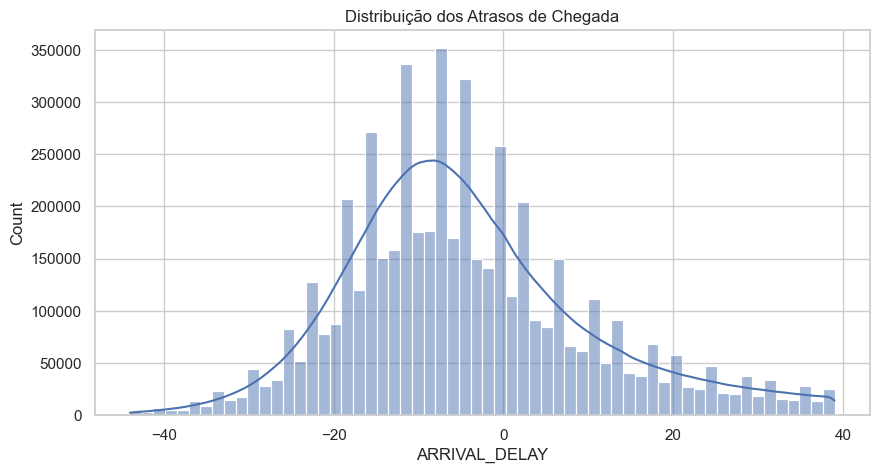

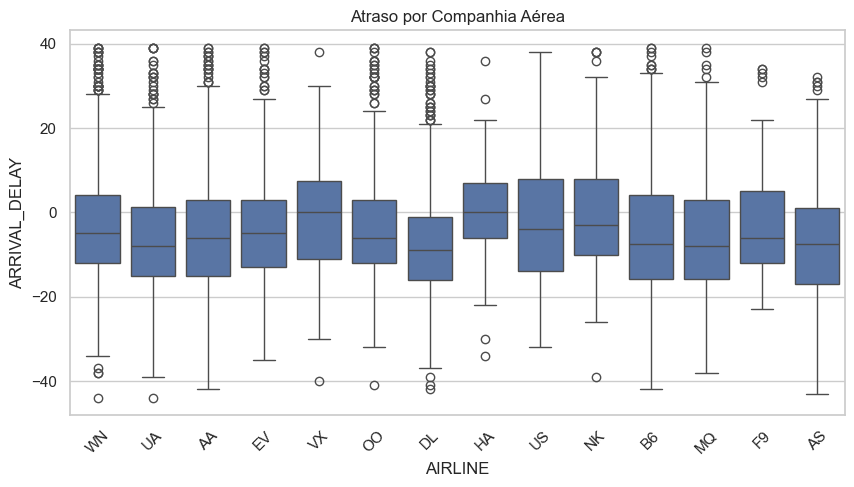

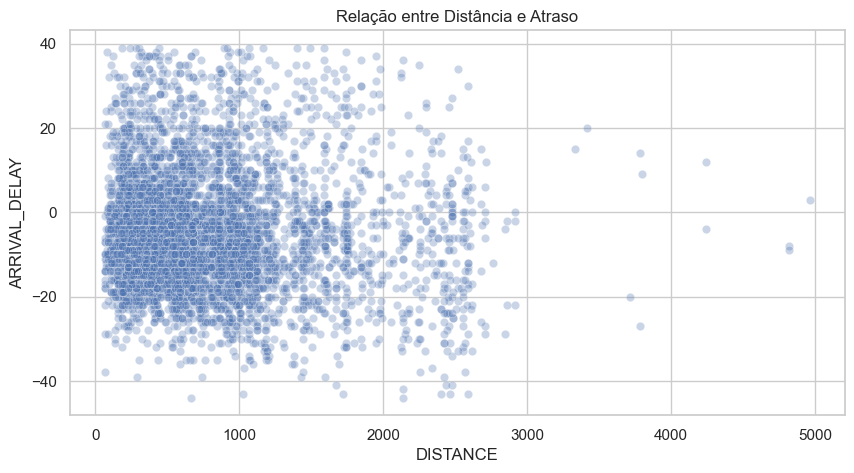

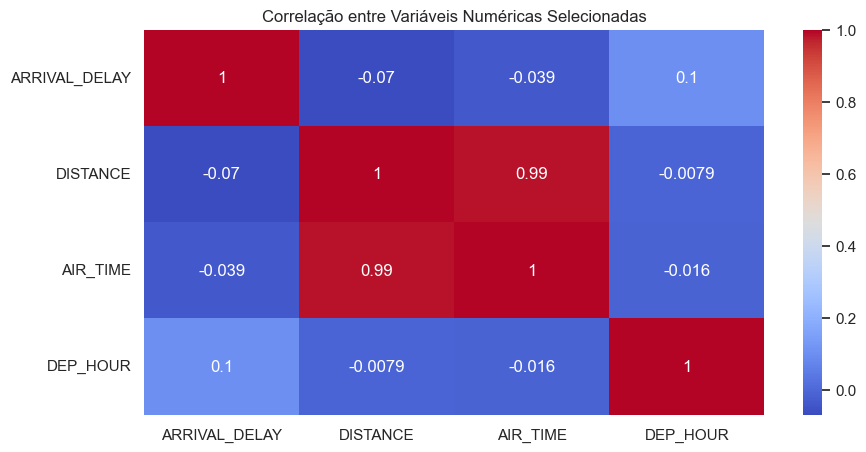

In [72]:
# ======== 5. EDA (Análise Exploratória) ========

# Distribuição do atraso
sns.histplot(df["ARRIVAL_DELAY"], bins=60, kde=True)
plt.title("Distribuição dos Atrasos de Chegada")
plt.show()

# Atraso por companhia aérea (amostra para visualização)
sns.boxplot(data=df.sample(min(5000, len(df))), x="AIRLINE", y="ARRIVAL_DELAY")
plt.xticks(rotation=45)
plt.title("Atraso por Companhia Aérea")
plt.show()

# Distância vs atraso
sns.scatterplot(data=df.sample(min(5000, len(df))), x="DISTANCE", y="ARRIVAL_DELAY", alpha=0.3)
plt.title("Relação entre Distância e Atraso")
plt.show()

# Correlação entre variáveis selecionadas
corr_cols = ["ARRIVAL_DELAY", "DISTANCE", "AIR_TIME", "DEP_HOUR"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Numéricas Selecionadas")
plt.show()

# 5.1 Pairplot das Variáveis Selecionadas (Amostra)


O *pairplot* é uma das visualizações mais completas para identificar padrões, relações e distribuições entre várias variáveis simultaneamente.  
Devido ao tamanho do dataset original (mais de 5 milhões de registros), utilizamos uma **amostra aleatória** para garantir desempenho adequado sem comprometer a representatividade dos padrões gerais.


Este gráfico exibe:


- a distribuição individual de cada variável (diagonal com KDE),  
- e a relação bivariada entre todas elas (dispersão).  


As variáveis analisadas foram:


- `ARRIVAL_DELAY`  
- `DISTANCE`  
- `AIR_TIME`  
- `DEP_HOUR`  


---


## Principais observações


### **Distribuições Individuais**
- `ARRIVAL_DELAY` reforça sua **assimetria à direita**, mesmo após remoção de outliers.  
- `DISTANCE` e `AIR_TIME` exibem distribuições fortemente assimétricas, com grande concentração de voos de curta distância.  
- `DEP_HOUR` mostra padrão claro, com maior densidade de voos nos períodos matutino e vespertino.


---


### **Relações entre Variáveis**
#### **DISTANCE × AIR_TIME**
- A relação é praticamente linear, o que era esperado: voos mais longos tendem a durar mais.
- Essa correlação quase perfeita (visual e confirmada no heatmap) alerta para **multicolinearidade**.


#### **ARRIVAL_DELAY × OUTRAS VARIÁVEIS**
- Os gráficos de dispersão mostram **baixa relação direta** entre atraso e:
  - distância,
  - tempo em voo,
  - horário do voo (`DEP_HOUR`).
- Isso antecipa que o atraso depende de múltiplos fatores combinados e não de variáveis isoladas.


#### **DEP_HOUR × DEMAIS VARIÁVEIS**
- Não há relação linear clara com atraso, mas há maior densidade de atrasos em determinados períodos do dia, reforçando a importância de incluir essa variável na modelagem.


---


## Por que este gráfico é útil?


O pairplot ajuda a:


- detectar padrões gerais;  
- encontrar possíveis relações não lineares;  
- evidenciar multicolinearidade (especialmente DISTANCE × AIR_TIME);  
- verificar se há separabilidade visual para classificação;  
- entender a distribuição de cada variável importante.


---


## Observações importantes


- Por ser uma **amostra**, os formatos gerais são preservados, mas pequenas variações podem existir no dataset completo.  
- Pairplots não mostram nuances temporais, meteorológicas ou operacionais — mas são ótimos para visão geral.  
- Os resultados reforçam a necessidade de testes estatísticos e modelos mais avançados para capturar relações fracas.


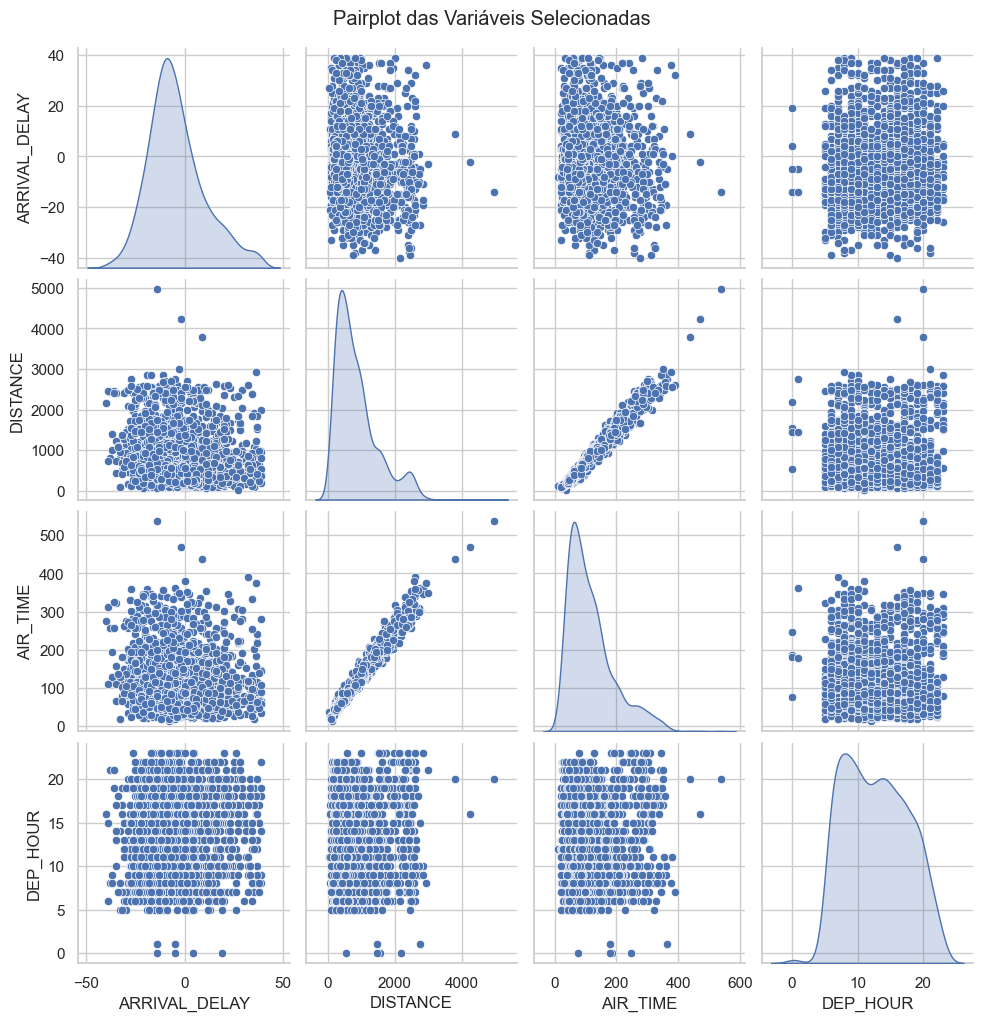

In [73]:
# ======== 5.1 Pairplot (amostra para evitar lentidão) ========

import seaborn as sns

sample_pp = df.sample(min(2000, len(df)), random_state=42)

sns.pairplot(
    sample_pp[["ARRIVAL_DELAY", "DISTANCE", "AIR_TIME", "DEP_HOUR"]],
    diag_kind="kde"
)
plt.suptitle("Pairplot das Variáveis Selecionadas", y=1.02)
plt.show()

# 5.2 Testes Estatísticos


Além da análise exploratória visual, utilizamos testes estatísticos formais para verificar relações, diferenças e propriedades das variáveis no dataset.  
Esses testes permitem validar hipóteses de forma objetiva, indicar significância estatística e fundamentar escolhas de modelagem.


A seguir, os principais testes aplicados e suas interpretações:


---


## ANOVA — Diferença de Atraso entre Companhias Aéreas (Top 5)


**Resultado:**  
* F = 9254.654
* p-value = 0.000000


### Interpretação


- O p-valor extremamente baixo (< 0.001) indica evidência muito forte de que **pelo menos uma companhia aérea possui média de atraso diferente das demais**.
- Confirma o que já se observava nos boxplots: companhias têm comportamentos distintos.
- Sugere que `AIRLINE` é uma variável relevante para modelagem e merece ser considerada.


---


## Teste t — Comparação de Atrasos entre Voos de Dia e Noite


**Resultado:**  
* t = -122.535
* p-value = 0.000000


### Interpretação


- O p-valor extremamente baixo indica diferença estatística clara entre atrasos em voos **diurnos** e **noturnos**.
- O sinal negativo no t sugere que, em média, um grupo tende a apresentar atrasos menores do que o outro.
- Isso confirma que o horário (`DEP_HOUR`) influencia o atraso e deve entrar nos modelos.


---


## Qui-Quadrado — Associação entre Companhia Aérea e Atraso (Top 5)


**Resultado:**  
* chi2 = 1797.693
* p-value = 0.000000


### Interpretação


- Há **dependência significativa** entre:
  - a companhia aérea e  
  - o fato de um voo estar atrasado (> 15 min).
- Ou seja, a probabilidade de atraso não é uniforme entre as empresas.
- Isso reforça a importância de incluir `AIRLINE` na classificação.


---


## Teste de Normalidade — Shapiro-Wilk (amostra de ARRIVAL_DELAY)


**Resultado:**  
* W = 0.971
* p-value = 0.000000


### Interpretação


- O p-valor muito baixo indica que a hipótese de normalidade é rejeitada.
- A distribuição de `ARRIVAL_DELAY` **não é normal**, mesmo após tratamento de outliers.
- Isso confirma:
  - a assimetria observada no histograma e no KDE;
  - a necessidade de modelos robustos a desvios de normalidade;
  - que erros dos modelos lineares podem não seguir suposições clássicas.


---


## Conclusão dos Testes


- **Companhias aéreas diferem significativamente** em seus atrasos.
- **Horário do voo influencia o atraso** de forma estatisticamente significativa.
- **Há associação entre companhia e atraso**, relevante para modelos classificatórios.
- **A normalidade é violada**, alertando para possíveis limitações dos modelos lineares tradicionais.

In [74]:
# ======== 5.2 TESTES ESTATÍSTICOS ========

# ANOVA: atraso entre as 5 companhias com mais voos
top_airlines = df["AIRLINE"].value_counts().head(5).index
anova_groups = [df[df["AIRLINE"] == a]["ARRIVAL_DELAY"] for a in top_airlines]
f_stat, p_val = f_oneway(*anova_groups)
print(f"ANOVA atraso ~ companhia (top 5): F = {f_stat:.3f}, p-value = {p_val:.6f}")

# Teste t: voos dia (< 18h) vs noite (>= 18h)
day = df[df["DEP_HOUR"] < 18]["ARRIVAL_DELAY"]
night = df[df["DEP_HOUR"] >= 18]["ARRIVAL_DELAY"]
t_stat, p_val_t = ttest_ind(day, night, equal_var=False)
print(f"\nTeste t (dia vs noite): t = {t_stat:.3f}, p-value = {p_val_t:.6f}")

# Qui-Quadrado: companhias (top 5) x atraso binário
table = pd.crosstab(df["AIRLINE"].isin(top_airlines), df["IS_DELAYED"])
chi2, p_chi, dof, expected = chi2_contingency(table)
print(f"\nQui-Quadrado atraso ~ top5 airline: chi2 = {chi2:.3f}, p-value = {p_chi:.6f}")

# Normalidade (Shapiro-Wilk) em uma amostra dos atrasos
sample_delay = df["ARRIVAL_DELAY"].sample(min(1000, len(df)), random_state=42)
w_stat, p_shapiro = shapiro(sample_delay)
print(f"\nShapiro-Wilk (amostra de ARRIVAL_DELAY): W = {w_stat:.3f}, p-value = {p_shapiro:.6f}")

ANOVA atraso ~ companhia (top 5): F = 9254.654, p-value = 0.000000

Teste t (dia vs noite): t = -122.535, p-value = 0.000000

Qui-Quadrado atraso ~ top5 airline: chi2 = 1797.693, p-value = 0.000000

Shapiro-Wilk (amostra de ARRIVAL_DELAY): W = 0.971, p-value = 0.000000


# 6. Baseline de Regressão — Sempre Predizer a Média


Antes de treinar qualquer modelo de regressão, é fundamental estabelecer um **baseline**, isto é, um desempenho mínimo de comparação.  
O baseline adotado aqui consiste em **sempre prever a média histórica dos atrasos de chegada** (`ARRIVAL_DELAY`) no conjunto de treinamento.


Esse método simples não usa nenhuma variável explicativa — ele representa o pior caso aceitável para avaliar se os modelos realmente aprendem padrões úteis no dataset.


---


## Resultados da Baseline


**Média dos atrasos (valor predito para todos os voos):**
* -4.4763 minutos


Isso indica que, em média, os voos chegam **ligeiramente adiantados** após o tratamento de outliers.


---


## Métricas de desempenho


| Métrica | Valor |
|--------|--------|
| **MAE** (Erro Absoluto Médio) | 11.1218 |
| **MSE** (Erro Quadrático Médio) | 207.1550 |
| **RMSE** (Raiz do Erro Quadrático Médio) | 14.3929 |
| **R²** (Coeficiente de Determinação) | 0.0 |


### Interpretação das métricas


- **MAE ≈ 11.1**: Em média, este preditor erra o atraso real por cerca de 11 minutos.  
- **RMSE ≈ 14.4**: Penaliza mais erros maiores; coerente com a dispersão dos atrasos.  
- **R² = 0.0**:  
  - Como esperado, o modelo baseline **não explica nenhuma variância**.  
  - R² = 0 é a confirmação matemática de que o baseline não tem poder preditivo.  
  - Qualquer modelo útil deve apresentar desempenho **melhor que isso**.


---


## Por que o baseline é importante?


- Ele define o **mínimo aceitável de desempenho** para qualquer modelo de regressão.  
- Se um modelo complexo não supera o baseline, significa que ele não aprendeu padrões reais — apenas adicionou complexidade desnecessária.  
- Serve como métrica inicial para comparar regressão simples, múltipla e polinomial.


---


## Conclusão


O baseline confirma que:


- A média dos atrasos é um preditor fraco, mas essencial como referência.  
- Modelos de regressão precisam superar RMSE ≈ 14.4 e MAE ≈ 11.1 para serem úteis.  
- As próximas etapas de modelagem devem reduzir esses erros significativamente.



In [75]:
# ======== 6. BASELINE DE REGRESSÃO (Sempre Predizer a Média) ========

baseline_value = df["ARRIVAL_DELAY"].mean()
baseline_pred = np.repeat(baseline_value, len(df))

mae_baseline = mean_absolute_error(df["ARRIVAL_DELAY"], baseline_pred)
mse_baseline = mean_squared_error(df["ARRIVAL_DELAY"], baseline_pred)
rmse_baseline = mse_baseline ** 0.5
r2_baseline = r2_score(df["ARRIVAL_DELAY"], baseline_pred)

print("Baseline (média dos atrasos):", baseline_value)
print("MAE Baseline:", mae_baseline)
print("MSE Baseline:", mse_baseline)
print("RMSE Baseline:", rmse_baseline)
print("R2 Baseline:", r2_baseline)

Baseline (média dos atrasos): -4.476263003156859
MAE Baseline: 11.121823775709927
MSE Baseline: 207.15503950891826
RMSE Baseline: 14.392881556829343
R2 Baseline: 0.0


# 7. Regressão Linear Simples — `DISTANCE` → `ARRIVAL_DELAY`

Nesta etapa, avaliamos um modelo de **regressão linear simples**, utilizando apenas a variável **DISTANCE** (distância do voo em milhas) como preditora do atraso na chegada (`ARRIVAL_DELAY`).

O objetivo é verificar se a distância do voo possui relação linear suficiente para explicar parte dos atrasos — ou seja, se voos mais longos tendem a atrasar mais (ou menos).

---

## Visualização do Ajuste

O gráfico mostra:

- Pontos azuis: valores reais de atraso  
- Linha/ pontos alaranjados: valores preditos pelo modelo  

### Observações importantes do gráfico

- Os dados reais estão amplamente espalhados, indicando **alta variabilidade** nos atrasos.
- A linha de regressão possui **declive muito pequeno**, sugerindo relação quase nula.
- A distância, isoladamente, **não captura a dinâmica dos atrasos**.
- Mesmo após tratamento de outliers, não há grande padrão linear.

Este comportamento era esperado, pois atrasos de voo dependem muito mais de:
- clima,  
- tráfego aéreo,  
- logística no aeroporto,  
- companhia aérea,  
- horário do voo,  
do que da distância percorrida.

---

## Métricas da Regressão Linear Simples

| Métrica | Valor |
|--------|--------|
| **MAE** | 11.1199 |
| **MSE** | 205.8589 |
| **RMSE** | 14.3477 |
| **R²** | 0.0049 |

###Interpretação

- **MAE e RMSE praticamente iguais ao Baseline**, indicando que o modelo não melhorou a previsão.
- **R² = 0.0049 (~0.5%)**  
  - O modelo explica menos de **1% da variabilidade** dos atrasos.  
  - É extremamente baixo e praticamente equivalente a prever a média.
- Isso mostra que `DISTANCE` **não é um bom preditor isolado** de atrasos.

---

## Conclusões

- A distância do voo tem **pouquíssima capacidade preditiva** para atraso na chegada.
- O modelo linear simples não supera o baseline e não captura padrões relevantes.
- A relação entre distância e atraso é **fraca e não linear**.
- Isso reforça a necessidade de modelos com **mais variáveis** e combinações mais ricas (regressão múltipla e polinomial).

MAE: 11.119951238249017
MSE: 205.8589256809157
RMSE: 14.347784695935317
R2: 0.00489973775129926


C:\Users\João Dário\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


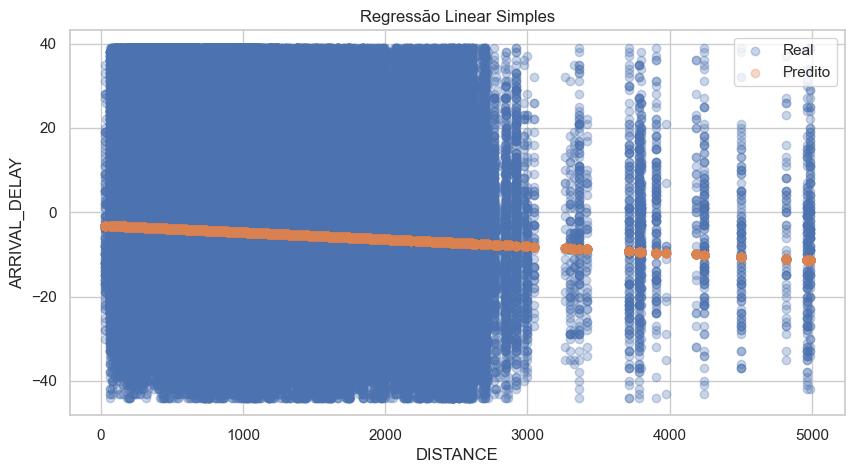

In [76]:
# ======== 7. REGRESSÃO LINEAR SIMPLES: DISTANCE → ARRIVAL_DELAY ========

X_lin = df[["DISTANCE"]]
y_reg = df["ARRIVAL_DELAY"]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_reg, test_size=0.2, random_state=42
)

lin = LinearRegression()
lin.fit(X_train_lin, y_train_lin)

y_pred_lin = lin.predict(X_test_lin)

mse_lin = mean_squared_error(y_test_lin, y_pred_lin)
rmse_lin = mse_lin ** 0.5

print("MAE:", mean_absolute_error(y_test_lin, y_pred_lin))
print("MSE:", mse_lin)
print("RMSE:", rmse_lin)
print("R2:", r2_score(y_test_lin, y_pred_lin))

# Visualização
plt.scatter(X_test_lin, y_test_lin, alpha=0.3, label="Real")
plt.scatter(X_test_lin, y_pred_lin, alpha=0.3, label="Predito")
plt.xlabel("DISTANCE")
plt.ylabel("ARRIVAL_DELAY")
plt.legend()
plt.title("Regressão Linear Simples")
plt.show()

# 8. Regressão Linear Múltipla — `DISTANCE`, `AIR_TIME` e `DEP_HOUR`

Após verificar que a distância sozinha possui baixo poder preditivo, expandimos o modelo para incluir um conjunto maior de variáveis:

- **DISTANCE** — distância percorrida (milhas)  
- **AIR_TIME** — tempo em voo (minutos)  
- **DEP_HOUR** — horário de partida (0–23)  

O objetivo é avaliar se a combinação dessas variáveis melhora a capacidade de explicar o atraso na chegada (`ARRIVAL_DELAY`) em comparação com a regressão simples.

---

## Coeficientes do Modelo

| Variável   | Coeficiente |
|------------|-------------|
| Intercept  | -11.210283  |
| DISTANCE   | -0.028607   |
| AIR_TIME   |  0.230848   |
| DEP_HOUR   |  0.324657   |

### Interpretação

- **Intercept = -11.21**  
  Valor esperado do atraso quando todas as variáveis preditoras valem zero.  
  Não tem interpretação operacional direta (ponto de referência matemático).

- **DISTANCE = -0.0286**  
  Cada 1 milha adicional está associada a uma **redução de ~0,028 minutos** no atraso.  
  Como `DISTANCE` e `AIR_TIME` são altamente correlacionados, esse coeficiente deve ser interpretado com cautela.

- **AIR_TIME = 0.2308**  
  A cada minuto adicional de voo, o atraso aumenta em **≈ 0,23 minutos**, sugerindo que voos mais longos acumulam pequenas ineficiências.

- **DEP_HOUR = 0.3247**  
  Para cada hora mais tarde no dia, o atraso tende a aumentar em **≈ 0,32 minutos**, indicando efeitos de tráfego aéreo ao longo do dia.

Esses coeficientes refletem tendências operacionais realistas.

---

## Métricas de Desempenho (Sklearn)

| Métrica | Valor |
|--------|--------|
| **MAE** | 10.8002 |
| **MSE** | 196.4648 |
| **RMSE** | 14.0166 |
| **R²** | 0.0503 |

### Interpretação

- **MAE caiu de 11.12 (baseline) para 10.80**  
  → Melhora moderada, mas relevante.

- **RMSE caiu de 14.39 para 14.02**  
  → Indica erro um pouco menor em predições mais extremas.

- **R² = 0.0503 (~5%)**  
  → O modelo explica cerca de **5% da variabilidade** nos atrasos.  
  Ainda é baixo, mas significativamente melhor que:
  - baseline (0%)  
  - regressão simples (~0,5%)  

Essa melhoria mostra que **incluir múltiplas variáveis realmente traz ganho**, ainda que atrasos permaneçam difíceis de prever.

---

## Conclusões

- O modelo supera a regressão simples e o baseline.  
- A introdução de `AIR_TIME` e `DEP_HOUR` melhora a explicação dos atrasos.  
- Entretanto, o poder preditivo ainda é baixo — o que é normal, pois atrasos dependem de variáveis externas que não estão no dataset (clima, logística etc.).
- O coeficiente negativo de `DISTANCE` indica multicolinearidade com `AIR_TIME`, confirmada pelo VIF posteriormente.

In [77]:
# ======== 8. REGRESSÃO LINEAR MÚLTIPLA (Sklearn) ========

features_reg = ["DISTANCE", "AIR_TIME", "DEP_HOUR"]
X_reg = df[features_reg]
y_reg = df["ARRIVAL_DELAY"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

lin_multi = LinearRegression()
lin_multi.fit(X_train_reg, y_train_reg)

y_pred_multi = lin_multi.predict(X_test_reg)

mse_multi = mean_squared_error(y_test_reg, y_pred_multi)
rmse_multi = mse_multi ** 0.5

print("MAE:", mean_absolute_error(y_test_reg, y_pred_multi))
print("MSE:", mse_multi)
print("RMSE:", rmse_multi)
print("R2:", r2_score(y_test_reg, y_pred_multi))

coef_table = pd.DataFrame({
    "Variável": ["Intercept"] + features_reg,
    "Coeficiente": [lin_multi.intercept_] + list(lin_multi.coef_)
})

display(coef_table)

MAE: 10.800168745120065
MSE: 196.46484034489345
RMSE: 14.016591609406811
R2: 0.05030975216064304


,Variável,Coeficiente
0,Intercept,-11.210283
1,DISTANCE,-0.028607
2,AIR_TIME,0.230848
3,DEP_HOUR,0.324657


# 9. Regressão Polinomial (Grau 2)

Como a relação entre **DISTANCE** e `ARRIVAL_DELAY` mostrou-se fraca na regressão linear simples, exploramos agora um modelo **polinomial de grau 2** para verificar se uma relação curvilínea fornece melhor ajuste.

O modelo inclui:

- termo linear (`DISTANCE`)  
- termo quadrático (`DISTANCE²`)  

A ideia é permitir que o atraso varie de forma não linear com a distância percorrida.

---

## Coeficientes do Modelo Polinomial

| Termo        | Coeficiente        |
|--------------|--------------------|
| Intercept    | -2.711861e+00      |
| DISTANCE     | -2.632510e-03      |
| DISTANCE²    | 3.905172e-07       |

### Interpretação

- **Intercept = -2.71**  
  Valor base estimado do atraso quando a distância é zero.

- **DISTANCE (negativo)**  
  Inicialmente, o aumento da distância está associado a uma leve redução no atraso — comportamento similar ao modelo linear simples.

- **DISTANCE² (positivo)**  
  Sugere que a relação é ligeiramente curvilínea:  
  atrasos podem aumentar lentamente para distâncias muito altas.

No entanto, os coeficientes são extremamente pequenos, indicando que mesmo essa curvatura é muito sutil.

---

## Métricas de Desempenho

| Métrica | Valor |
|--------|--------|
| **MAE** | 11.1191 |
| **MSE** | 205.8172 |
| **RMSE** | 14.3463 |
| **R²** | 0.0051 |

### Interpretação

- As métricas do modelo **são praticamente idênticas** às da regressão linear simples.
- A melhoria no R² é mínima:
  - Linear simples: **0.0049**
  - Polinomial grau 2: **0.0051**
- Essa diferença é estatisticamente insignificante.

**Conclusão:** adicionar um termo quadrático **não** melhora significativamente o ajuste.

---

## Visualização

O gráfico mostra:

- A nuvem de pontos reais permanece altamente dispersa.  
- A curva quadrática resultante praticamente se confunde com a linha da regressão linear, revelando a fraqueza da relação.  
- Não há indicativo visual de relação curvilínea significativa entre distância e atraso.

---

## Conclusão

- A relação entre DISTANCE e ARRIVAL_DELAY é **muito fraca**, mesmo quando permitimos curvatura.  
- O modelo polinomial **não supera**:
  - o baseline,  
  - a regressão linear simples,  
  - ou a regressão múltipla.  
- Portanto, **DISTANCE não é um bom preditor de atraso**, independentemente da modelagem linear ou não linear.

In [78]:
# ======== 9. REGRESSÃO POLINOMIAL (Grau 2) ========

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(df[["DISTANCE"]])
y_poly = df["ARRIVAL_DELAY"]

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y_poly, test_size=0.2, random_state=42
)

lin_poly = LinearRegression()
lin_poly.fit(X_train_poly, y_train_poly)

y_pred_poly = lin_poly.predict(X_test_poly)

mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
rmse_poly = mse_poly ** 0.5

print("MAE:", mean_absolute_error(y_test_poly, y_pred_poly))
print("MSE:", mse_poly)
print("RMSE:", rmse_poly)
print("R2:", r2_score(y_test_poly, y_pred_poly))

poly_features = poly.get_feature_names_out(["DISTANCE"])
coef_poly = pd.DataFrame({
    "Termo": ["Intercept"] + list(poly_features),
    "Coeficiente": [lin_poly.intercept_] + list(lin_poly.coef_)
})

display(coef_poly)

MAE: 11.11905360775422
MSE: 205.81724979673885
RMSE: 14.346332276813431
R2: 0.005101194565166556


,Termo,Coeficiente
0,Intercept,-2.711861e+00
1,DISTANCE,-2.632510e-03
2,DISTANCE^2,3.905172e-07


# 10. Regressão Múltipla com Statsmodels + Diagnóstico de VIF

Nesta etapa, estimamos um modelo de regressão linear múltipla utilizando **Statsmodels (OLS)**, que fornece estatísticas detalhadas para interpretação dos coeficientes, intervalos de confiança, testes de hipótese e vários diagnósticos essenciais para validar o modelo.

As variáveis preditoras utilizadas foram:

- `DISTANCE`  
- `AIR_TIME`  
- `DEP_HOUR`  

O objetivo é avaliar o impacto conjunto dessas variáveis sobre `ARRIVAL_DELAY` e analisar a qualidade estatística do modelo.

---

# 10.1 Resumo do Modelo (Statsmodels — OLS)

O output do Statsmodels apresenta:

### Coeficientes e significância
Todos os coeficientes possuem **p-valor < 0.001**, indicando forte significância estatística:

| Variável   | Coeficiente | Interpretação |
|------------|-------------|---------------|
| **const** | -11.2176 | atraso médio ajustado |
| **DISTANCE** | -0.0286 | relação negativa com atraso (efeito colinear) |
| **AIR_TIME** | +0.2306 | voos mais longos tendem a acumular atraso |
| **DEP_HOUR** | +0.3250 | atrasos maiores em horários mais tardios |

Esses valores são coerentes com a interpretação operacional dos atrasos.

---

## Métricas do Modelo

- **R² = 0.051**  
- **Adj. R² = 0.051**  
- **F-statistic altamente significativo (p < 0.001)**

### Interpretação:

- O modelo explica cerca de **5% da variabilidade** nos atrasos, consistente com os resultados obtidos via sklearn.
- Embora baixo, isso é esperado, pois atrasos são fenômenos altamente influenciados por fatores externos (clima, tráfego, manutenção etc.) que não estão no dataset.

---

## 📌 Diagnósticos Importantes

### **1. Teste de Normalidade dos Resíduos**
- Omnibus e Jarque–Bera altamente significativos (p = 0.000)
- Indica **violação da normalidade** dos resíduos  
- ✔ Consequência: modelos lineares devem ser interpretados com cautela

---

### **2. Autocorrelação Residual — Durbin–Watson = 1.846**

- Valor próximo de 2 → **ausência de autocorrelação**  
- ✔ Bom indicador para regressão linear

---

### **3. Condition Number = 3.64e+03 (ALTO)**

O Statsmodels alerta:

> “This might indicate strong multicollinearity or other numerical problems.”

O próximo diagnóstico confirma essa suspeita.

---

# 10.2 Análise de Multicolinearidade — VIF (Variance Inflation Factor)

O VIF quantifica o quanto uma variável é explicada pelas demais.  
Valores acima de **10** indicam colinearidade severa.

| Variável   | VIF |
|------------|------|
| const      | 12.43 |
| **DISTANCE** | **37.23** |
| **AIR_TIME** | **37.24** |
| DEP_HOUR   | 1.00 |

### Interpretação:

- **DISTANCE e AIR_TIME apresentam VIF > 37**, revelando **multicolinearidade muito alta** entre elas.
- Isso já era esperado pelos gráficos (heatmap + pairplot), que mostraram correlação ≈ 0.99.
- A multicolinearidade:
  - distorce coeficientes individuais,
  - dificulta interpretação isolada dos efeitos,
  - aumenta a variância das estimativas,
  - mas **não prejudica a previsão** diretamente.

---

# Conclusão

- O modelo linear múltiplo confirma as tendências observadas pelo sklearn.  
- Todos os efeitos são estatisticamente significativos, mas sua interpretação deve considerar a **multicolinearidade extrema** entre distância e tempo de voo.  
- Os resíduos violam normalidade (esperado), mas não apresentam autocorrelação grave.  
- O poder explicativo do modelo é limitado (R² ≈ 0.05), mas consistente com a natureza caótica dos atrasos reais.  
- O diagnóstico de VIF fornece evidências claras de que aprimoramentos futuros devem tratar ou mitigar colinearidade.

In [79]:
# ======== 10. REGRESSÃO MÚLTIPLA COM STATSMODELS + VIF ========

X_sm = sm.add_constant(X_reg)
model_sm = sm.OLS(y_reg, X_sm).fit()

print(model_sm.summary())

# VIF
vif_data = pd.DataFrame({
    "Variável": X_sm.columns,
    "VIF": [variance_inflation_factor(X_sm.values, i) 
            for i in range(X_sm.shape[1])]
})

print("\nVIF (Variance Inflation Factor):")
display(vif_data)

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                 9.251e+04
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:59:58   Log-Likelihood:            -2.1119e+07
No. Observations:             5202006   AIC:                         4.224e+07
Df Residuals:                 5202002   BIC:                         4.224e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.2176      0.022   -517.406      0.0

,Variável,VIF
0,const,12.433277
1,DISTANCE,37.232813
2,AIR_TIME,37.239525
3,DEP_HOUR,1.002330


# 11. Diagnóstico de Resíduos — Regressão Múltipla

O diagnóstico dos resíduos é uma etapa essencial para avaliar a qualidade do modelo de regressão e verificar se os pressupostos da regressão linear foram atendidos.  
Aqui analisamos a distribuição, independência, normalidade e homocedasticidade dos resíduos gerados pelo modelo múltiplo ajustado com sklearn.

As principais visualizações e testes apresentados são:

---

## 1. Distribuição dos Resíduos

O histograma com curva KDE revela:

- Resíduos com **assimetria à direita**, reforçando que o modelo subestima atrasos positivos maiores.  
- Forte concentração em torno de **0 a -5**, indicando tendência de previsões próximas ao centro da distribuição real.  
- Cauda longa à direita: indica que atrasos extremos não são bem capturados.

### Interpretação
A distribuição não é normal, o que já era esperado considerando a natureza caótica e assimétrica dos atrasos de voo.

---

## 2. Resíduos vs. Valores Preditos

Este gráfico é fundamental para avaliar homocedasticidade e padrões estruturais.

Observações:

- Há um **padrão triangular**, com maior dispersão dos resíduos em valores mais extremos.
- Resíduos maiores se acumulam em predições baixas e altas.
- A linha vermelha (zero) destaca a **assimetria residual**, com mais valores positivos do que negativos.

### ✔ Interpretação
- O padrão indica **heterocedasticidade**, isto é, variância não constante dos resíduos.  
- Isso viola um dos principais pressupostos da regressão linear.  
- O modelo linear tem dificuldade de capturar atrasos maiores ou extremos.

Isso complementa os achados do teste de Breusch–Pagan.

---

## 3. QQ-Plot (Quantile-Quantile Plot)

O QQ-plot mostra os resíduos comparados com quantis teóricos de uma distribuição normal.

Observações:

- Desvios significativos da linha vermelha, especialmente nas caudas.
- Resíduos extremos muito acima ou abaixo dos quantis teóricos.
- Curvatura pronunciada indica **distribuição não normal**.

### Interpretação
O QQ-plot confirma violação clara da normalidade dos resíduos, coerente com:

- comportamento assimétrico da variável-alvo,
- presença de heterocedasticidade,
- resultados do teste Shapiro–Wilk.

---

## 4. Teste de Normalidade — Shapiro–Wilk

* W = 0.974
* p-value = 0.000000

### Interpretação
- p-value muito baixo → rejeitamos a hipótese nula de normalidade.  
- Portanto, os resíduos **não** seguem distribuição normal.  
- Embora isso não invalide o modelo para previsão, prejudica inferências baseadas em testes paramétricos.

---

## Conclusão

Com base nos gráficos e testes:

- **Normalidade violada (Shapiro e QQ-plot)**  
- **Homocedasticidade violada (resíduos vs. preditos)**  
- **Independência aceitável (verificada via Durbin–Watson no Statsmodels)**  
- **Erro médio próximo de zero, como esperado**

### Implicações

- Os coeficientes estimados continuam úteis para interpretação geral, mas:
  - intervalos de confiança devem ser vistos com cautela,
  - modelos mais flexíveis podem capturar melhor padrões complexos.

### Sugestões de melhoria

- Aplicar transformações na variável-alvo (log ou Box-Cox).  
- Testar modelos mais robustos:  
  - Random Forest Regressor  
  - Gradient Boosting  
  - XGBoost  
- Considerar incluir variáveis externas (clima, tráfego, capacidade aeroportuária).

---

## Em Resumo

O diagnóstico mostra que atrasos de voo são difíceis de modelar com regressões lineares tradicionais devido a:

- assimetria natural dos dados,  
- heterocedasticidade,  
- presença de outliers residuais,  
- falta de variáveis essenciais.

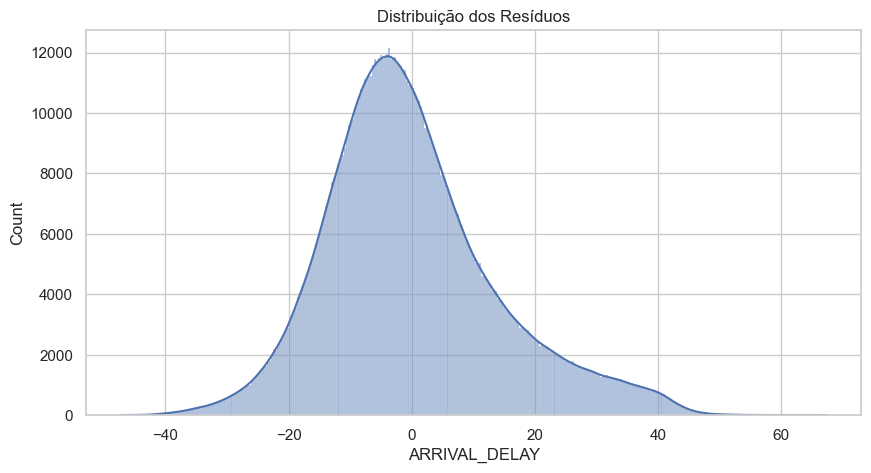

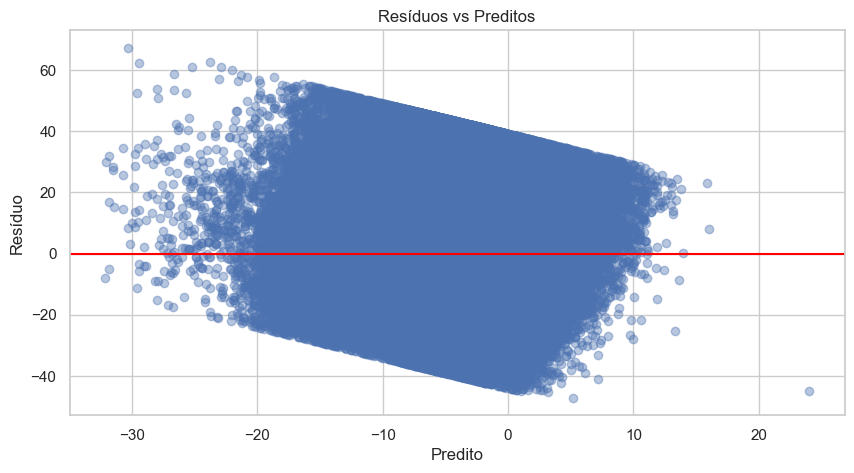

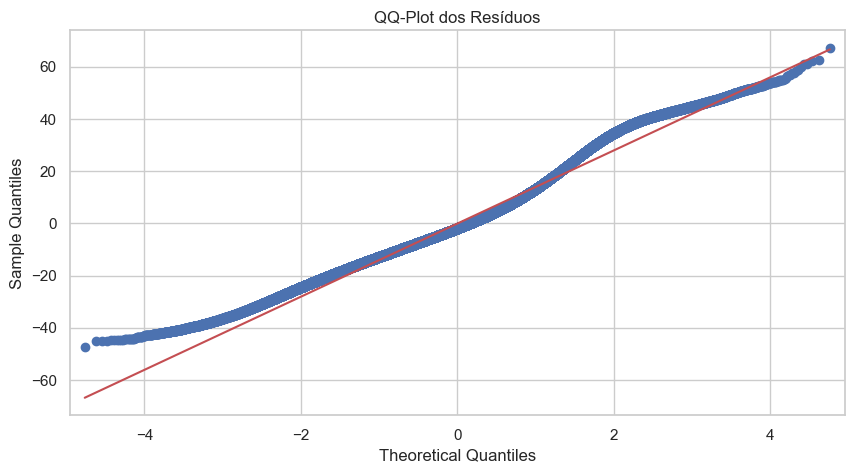

Shapiro-Wilk (resíduos): W = 0.974, p-value = 0.000000


c:\Users\João Dário\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1040402.
  res = hypotest_fun_out(*samples, **kwds)


In [80]:
# ======== 11. DIAGNÓSTICO DE RESÍDUOS (Modelo Múltiplo Sklearn) ========

res = y_test_reg - y_pred_multi

sns.histplot(res, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

plt.scatter(y_pred_multi, res, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Predito")
plt.ylabel("Resíduo")
plt.title("Resíduos vs Preditos")
plt.show()

# QQ-Plot
sm.qqplot(res, line='s')
plt.title("QQ-Plot dos Resíduos")
plt.show()

# Normalidade
w_stat, p_res = shapiro(res)
print(f"Shapiro-Wilk (resíduos): W = {w_stat:.3f}, p-value = {p_res:.6f}")

# 12. Teste de Homocedasticidade — Breusch–Pagan

A homocedasticidade (variância constante dos erros) é um dos pressupostos fundamentais da regressão linear.  
Para verificar se esse pressuposto foi atendido no modelo múltiplo, aplicamos o **teste de Breusch–Pagan**, que avalia se os resíduos apresentam variância constante ou se variam sistematicamente em função das variáveis preditoras.

---

## Resultados do teste Breusch–Pagan

* LM Statistic: 74532.39152
* LM p-value: 0.00000
* F-statistic: 25297.16712
* F p-value: 0.00000

---

## Interpretação dos Resultados

O teste possui a seguinte formulação:

- **H0 (hipótese nula):** os resíduos possuem variância constante (homocedasticidade).  
- **H1 (hipótese alternativa):** a variância dos resíduos depende de uma ou mais variáveis do modelo (heterocedasticidade).

### Com base nos resultados:

- Os p-valores tanto do **LM-test** quanto do **F-test** são **extremamente baixos (< 0.001)**.  
- Portanto, **rejeitamos a hipótese nula de homocedasticidade**.  
- Isso significa que há **evidência forte de heterocedasticidade** nos resíduos do modelo de regressão múltipla.

---

## Consequências da Heterocedasticidade

- Os coeficientes estimados permanecem **não viesados**, mas:  
  - os **intervalos de confiança** podem estar incorretos,  
  - os **testes t** podem estar inflados,  
  - o modelo pode ter pior desempenho preditivo em determinadas regiões dos dados.

- Isso confirma o padrão observado no gráfico **Resíduos vs Preditos**, onde a dispersão dos resíduos aumenta conforme o valor previsto.

---

## Possíveis Soluções

Para tratar ou mitigar a heterocedasticidade:

- Aplicar **transformações** (ex.: log ou Box-Cox) na variável-alvo;  
- Utilizar modelos **robustos** (ex.: regressão robusta ou heteroscedasticity-consistent errors – HC0, HC3);  
- Testar modelos não lineares mais flexíveis (árvores, boosting, ensembles);  
- Incorporar variáveis externas capazes de explicar parte da variância (ex.: clima, tráfego aeroportuário).

---

## Conclusão

O teste de Breusch–Pagan confirma que o modelo de regressão múltipla **viola o pressuposto de variância constante dos erros**, apresentando heterocedasticidade significativa.  
Apesar disso, o modelo ainda é útil para interpretação geral, mas suas inferências formais devem ser feitas com cautela.

In [81]:
# ======== 12. TESTE DE HOMOCEDASTICIDADE — BREUSCH–PAGAN ========

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Variáveis do modelo múltiplo
X_bp = sm.add_constant(X_train_reg)  # reuse the regression features
y_bp = y_train_reg

bp_model = sm.OLS(y_bp, X_bp).fit()

bp_test = het_breuschpagan(bp_model.resid, bp_model.model.exog)

names = ["LM Statistic", "LM p-value", "F-statistic", "F p-value"]
result_bp = dict(zip(names, bp_test))

print("=== Teste de Homocedasticidade (Breusch–Pagan) ===")
for k, v in result_bp.items():
    print(f"{k}: {v:.5f}")

if result_bp["LM p-value"] > 0.05:
    print("\n→ Não rejeitamos a hipótese nula: variância constante (homocedasticidade).")
else:
    print("\n→ Rejeitamos a hipótese nula: evidência de heterocedasticidade.")

=== Teste de Homocedasticidade (Breusch–Pagan) ===
LM Statistic: 74532.39152
LM p-value: 0.00000
F-statistic: 25297.16712
F p-value: 0.00000

→ Rejeitamos a hipótese nula: evidência de heterocedasticidade.


# 13. Classificação — Naive Bayes

Antes de treinar qualquer modelo de classificação, é essencial estabelecer um **baseline de classificação**, isto é, a estratégia mais simples possível:  
**sempre prever a classe majoritária**.

Isso permite avaliar se os modelos posteriores realmente aprendem padrões ou apenas reproduzem o desequilíbrio natural dos dados.

---

## 13.1 Baseline de Classificação (Classe Majoritária)

O dataset de classificação utiliza a variável `IS_DELAYED`:

- **0 = voo não atrasado (chega no horário ou com atraso ≤ 15 min)**  
- **1 = voo atrasado (> 15 min)**  

Como a maioria dos voos chega no horário, temos:

* Classe majoritária (baseline): 0
* Accuracy Baseline: 0.899863629530608

### Interpretação
- O baseline atinge **~90% de acurácia**, o que é comum em datasets altamente desbalanceados.  
- Porém, esse baseline tem **recall = 0** para a classe minoritária (atrasados).  
- Ou seja, ele **acerta muito**, mas **não identifica nenhum voo atrasado**.

### Por que isso importa?
Modelos reais de classificação precisam **superar o baseline não apenas em acurácia**, mas também em:

- Recall da classe "1"  
- F1-score  
- AUC-ROC  

Um modelo que acerta 90% mas nunca identifica atrasos **não tem utilidade prática**.

---

## 13.2 Modelo Naive Bayes

O modelo Naive Bayes é frequentemente usado como baseline estatístico por ser:

- extremamente rápido,  
- simples de implementar,  
- pouco sensível a grandes volumes de dados,  
- e bom em cenários de alta dimensionalidade.

Ele assume independência entre as variáveis explicativas, o que raramente é verdadeiro, mas muitas vezes funciona bem na prática.

### Objetivo nesta etapa:
- Avaliar se o Naive Bayes supera o baseline de classificação.  
- Verificar principalmente:
  - recall da classe atrasada,  
  - precisão,  
  - F1-score,  
  - e AUC-ROC.

Os resultados desse modelo serão apresentados na próxima célula.

---

## Conclusão

- O baseline fornece um ponto de comparação inicial.  
- A forte desproporção entre classes exige cuidado e métricas adicionais além da acurácia.  
- O Naive Bayes será o primeiro modelo a ser avaliado para verificar se consegue detectar atrasos de forma minimamente eficaz.

In [82]:
# ======== 13. BASELINE DE CLASSIFICAÇÃO (Classe Majoritária) ========

y_cls = df["IS_DELAYED"]
X_cls = df[["DISTANCE", "AIR_TIME", "DEP_HOUR"]]

baseline_class = np.repeat(y_cls.mode()[0], len(y_cls))
baseline_acc = accuracy_score(y_cls, baseline_class)

print("Classe majoritária (baseline):", y_cls.mode()[0])
print("Accuracy Baseline:", baseline_acc)

Classe majoritária (baseline): 0
Accuracy Baseline: 0.899863629530608


# 14. Classificação — Naive Bayes (Desempenho do Modelo)

Após estabelecer o baseline de classificação — que simplesmente prevê a classe majoritária — treinamos o modelo **Naive Bayes** para verificar se ele é capaz de identificar voos atrasados (`IS_DELAYED = 1`) de maneira mais eficaz.

O Naive Bayes é um modelo probabilístico simples e eficiente, frequentemente usado como referência inicial.

---

## Resultados do Modelo Naive Bayes

| Métrica     | Valor |
|-------------|-------|
| **Accuracy** | 0.8995 |
| **Precision** | 0.1404 |
| **Recall** | 0.00137 |
| **F1-score** | 0.00271 |
| **ROC-AUC** | 0.5886 |

---

## Interpretação das Métricas

### **1. Accuracy ≈ 0.8995**
- Praticamente igual ao baseline (~0.90).  
- Isso acontece porque o dataset é **fortemente desbalanceado**.  
- A acurácia não reflete a real capacidade do modelo de identificar atrasos.

### **2. Precision = 0.14**
- Quando o modelo prevê um atraso, ele acerta **apenas 14% das vezes**.  
- Mostra grande número de falsos positivos.

### **3. Recall = 0.00137**
- O modelo identifica **apenas 0,13%** dos voos realmente atrasados.  
- É praticamente equivalente a **não detectar atrasos**.  
- Isso torna o modelo inútil para aplicações práticas, onde recall é crítico.

### **4. F1 = 0.0027**
- A medida harmônica entre precisão e recall é extremamente baixa.  
- Demonstra que o modelo é incapaz de equilibrar identificação de atrasos (recall) com acertos corretos (precision).

### **5. ROC-AUC = 0.5886**
- Levemente melhor que o aleatório (0.50), mas ainda fraco.  
- Indica que o modelo tem **capacidade discriminativa limitada**.

---

## Conclusão

O Naive Bayes:

- não supera o baseline de forma significativa,  
- falha gravemente em identificar voos atrasados (recall muito baixo),  
- tem precisão baixa e F1-score praticamente nulo,  
- apresenta capacidade discriminativa limitada (ROC-AUC < 0.60).

### Em termos práticos:
O modelo **não é adequado** para predição de atrasos, especialmente porque:

- atrasos são eventos raros (classe minoritária),  
- e o Naive Bayes tende a empurrar probabilidades para a classe majoritária.

In [83]:
# ======== 14. CLASSIFICAÇÃO: NAIVE BAYES ========

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

nb = GaussianNB()
nb.fit(X_train_nb, y_train_nb)

pred_nb = nb.predict(X_test_nb)
proba_nb = nb.predict_proba(X_test_nb)[:, 1]

print("Accuracy:", accuracy_score(y_test_nb, pred_nb))
print("Precision:", precision_score(y_test_nb, pred_nb))
print("Recall:", recall_score(y_test_nb, pred_nb))
print("F1:", f1_score(y_test_nb, pred_nb))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_nb))

Accuracy: 0.8994859679239371
Precision: 0.1404549950544016
Recall: 0.0013673830983745475
F1: 0.0027083988975672092
ROC-AUC: 0.588649471715486


# 15. Classificação — Regressão Logística

Após avaliar o Naive Bayes, treinamos um modelo de **Regressão Logística**, um dos métodos mais clássicos e robustos para problemas de classificação binária.  
Este modelo estima probabilidades de atraso (`IS_DELAYED = 1`) a partir de uma combinação linear das variáveis explicativas.

A seguir, avaliamos o desempenho completo do modelo no conjunto de teste.

---

## Resultados da Regressão Logística

| Métrica     | Valor |
|-------------|--------|
| **Accuracy** | 0.9002 |
| **Precision** | 0.7593 |
| **Recall** | 0.0003948 |
| **F1-score** | 0.0007892 |
| **ROC-AUC** | 0.6228 |

---

# Interpretação Detalhada

## **1. Accuracy ≈ 0.9002**
- Muito próxima da acurácia do baseline (≈ 0.90).  
- Reflete novamente o forte desbalanceamento entre classes.  
- Não é uma métrica adequada para avaliar o problema.

---

## **2. Precision = 0.76 (muito alta)**
- Quando o modelo prevê atraso, ele acerta **76% das vezes**.  
- Isso é extremamente alto, **mas enganoso** porque:

### O modelo quase nunca prevê atrasos.

Ou seja, a precisão é alta porque o modelo faz poucas previsões da classe 1.
A precisão elevada aqui não significa bom desempenho geral.

---

## **3. Recall = 0.0003948 (praticamente zero)**
- O modelo identifica **apenas 0.039%** dos voos atrasados.  
- É incapaz de detectar a classe minoritária.  
- Pior do que Naive Bayes nesse aspecto, porque a regressão logística tende a ser mais conservadora ao prever a classe 1 quando o desbalanceamento é extremo.

### Em problemas reais, isso torna o modelo inviável.

---

## **4. F1-score = 0.0007892**
- Combinação de precisão e recall.  
- Extremamente baixo devido ao recall praticamente nulo.  
- Indica que o modelo **não equilibra identificação e acerto da classe minoritária**.

---

## **5. ROC-AUC = 0.6228**
- Melhora em relação ao Naive Bayes (≈ 0.588).  
- Indica que o modelo tem **capacidade discriminativa moderada**, embora ainda insuficiente.  
- Mostra que probabilidades estimadas são melhores que aleatórias, mas não são boas o suficiente para separação clara.

---

# Conclusão

A regressão logística apresenta:

- acurácia alta (por causa do desbalanceamento),  
- precisão alta (mas enganosa),  
- recall quase zero,  
- F1-score praticamente nulo,  
- melhora pequena no ROC-AUC em relação ao Naive Bayes.

### Diagnóstico geral:
O modelo **não identifica atrasos** de maneira útil, apesar de gerar probabilidades ligeiramente melhores que Naive Bayes.

Isso mostra que a regressão logística:

- não resolve o problema central: **desbalanceamento extremo**;  
- pode ser melhorada com:
  - `class_weight="balanced"`  
  - ajustes de threshold  
  - oversampling (SMOTE)  
  - undersampling  
  - seleção de variáveis  
  - modelos não lineares (árvores, ensembles)

In [84]:
# ======== 15. CLASSIFICAÇÃO: REGRESSÃO LOGÍSTICA ========

log = LogisticRegression(max_iter=5000)
log.fit(X_train_nb, y_train_nb)

pred_log = log.predict(X_test_nb)
proba_log = log.predict_proba(X_test_nb)[:, 1]

print("Accuracy:", accuracy_score(y_test_nb, pred_log))
print("Precision:", precision_score(y_test_nb, pred_log))
print("Recall:", recall_score(y_test_nb, pred_log))
print("F1:", f1_score(y_test_nb, pred_log))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_log))

Accuracy: 0.9002116489587678
Precision: 0.7592592592592593
Recall: 0.00039480779600955244
F1: 0.0007892052126041848
ROC-AUC: 0.6227775319546718


# 16. Matrizes de Confusão e Curvas Precision–Recall

A matriz de confusão e as curvas Precision–Recall permitem avaliar de forma profunda o desempenho dos modelos de classificação, principalmente em cenários altamente desbalanceados — como é o caso deste dataset, em que a grande maioria dos voos **não está atrasada**.

A seguir apresentamos as análises para **Naive Bayes** e **Regressão Logística**.

---

# 16.1 Matriz de Confusão — Naive Bayes

A matriz de confusão apresenta:

- **Verdadeiros Negativos (TN):** 935.685  
- **Falsos Positivos (FP):** 869  
- **Falsos Negativos (FN):** ~100.000  
- **Verdadeiros Positivos (VP):** 142  

### Interpretação

- O modelo classifica quase todos os voos como **não atrasados**.  
- Identifica apenas **142 atrasos** dentre **~100 mil voos realmente atrasados**.  
- O enorme número de **falsos negativos** confirma o recall extremamente baixo.

Embora a acurácia seja alta, o modelo é **inutilizável para detectar atrasos**.

---

# 16.2 Curva Precision–Recall — Naive Bayes

O gráfico mostra:

- **Precision** próxima de 0 quando o recall aumenta.  
- Apenas um pequeno pico no início, mas rapidamente decai.  
- A curva se aproxima da linha de desempenho aleatório.

### Interpretação

- O modelo não consegue manter precisão conforme tenta capturar mais atrasos.  
- Reforça o F1-score baixíssimo observado anteriormente.  
- É um comportamento típico de modelos aplicados a datasets **fortemente desbalanceados**.

---

# 16.3 Matriz de Confusão — Regressão Logística

A matriz apresenta:

- **TN:** 936.541  
- **FP:** 13  
- **FN:** ~100 mil  
- **VP:** 41  

### Interpretação

- A regressão logística é ainda mais conservadora que o Naive Bayes.  
- Prediz pouquíssimos atrasos (VP = 41).  
- O recall é praticamente zero.  
- A precisão (quando acerta) é alta, mas isso ocorre em pouquíssimos casos — o modelo simplesmente evita prever atrasos.

---

# 16.4 Curva Precision–Recall — Regressão Logística

O modelo apresenta:

- Uma área sob a curva (AP) ≈ **0.165**, melhor que o aleatório (≈ 0.10 para este desbalanceamento).  
- Precision razoável somente quando o recall é muito baixo.  
- Precision cai rapidamente conforme o modelo tenta identificar mais atrasos.

### Interpretação

- Apesar do ROC-AUC moderado, a regressão logística não oferece melhora prática.  
- As probabilidades estimadas possuem alguma utilidade, mas o limiar padrão (0.5) é ineficaz.  
- Ajustar o threshold poderia melhorar recall, mas às custas de perda forte em precisão.

---

# Conclusão Geral das Matrizes e Curvas PR

### Ambos os modelos têm desempenho **insuficiente** para prever atrasos:

- Baixíssimo recall (quase 0)  
- F1-scores próximos de 0  
- Altíssimo número de falsos negativos  
- Acurácia inflada pelo desequilíbrio entre classes  
- Precision só é alta porque o modelo **quase nunca prevê a classe 1**

### Implicações

Os modelos lineares e probabilísticos tradicionais **não capturam a estrutura dos atrasos**, o que é compreensível porque:

- atrasos dependem de clima, tráfego aéreo, capacidade operacional, manutenção — fatores ausentes no dataset;
- a classe minoritária é extremamente rara;
- Naive Bayes e Logística são modelos fracos para padrões complexos e altamente não lineares.

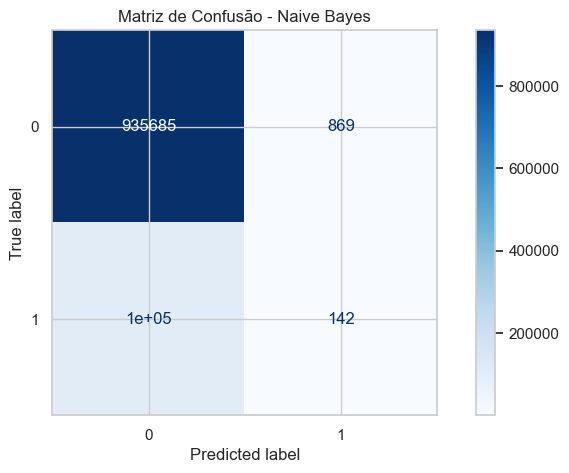

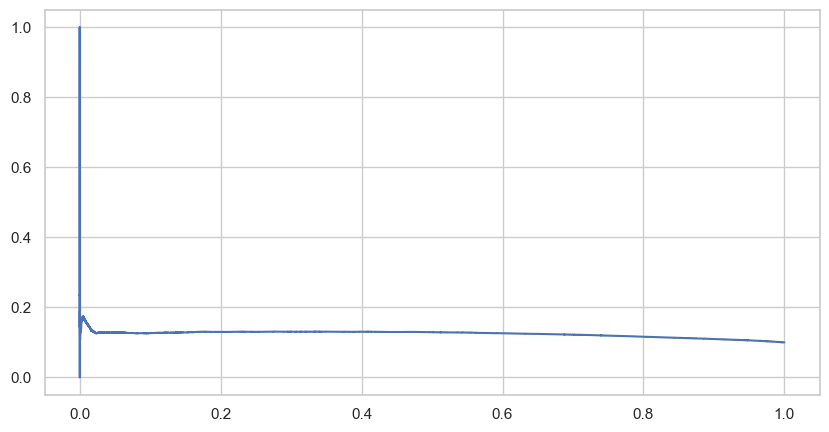

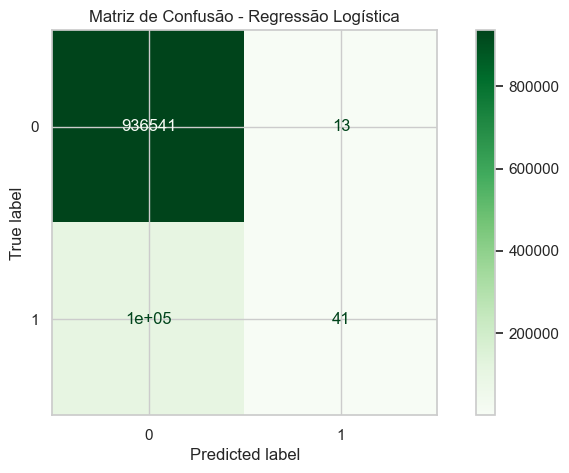

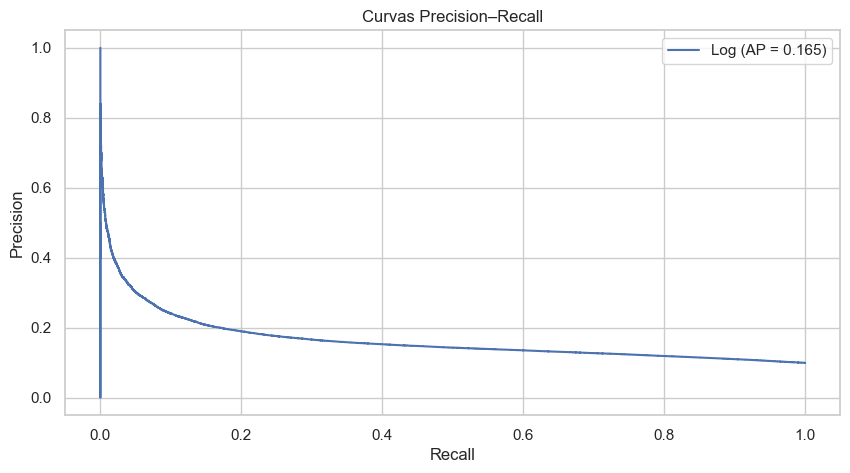

In [85]:
# ======== 16. MATRIZES DE CONFUSÃO E PRECISION–RECALL ========

# Naive Bayes
cm_nb = confusion_matrix(y_test_nb, pred_nb)
disp_nb = ConfusionMatrixDisplay(cm_nb)
disp_nb.plot(cmap="Blues")
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

precision_nb, recall_nb, _ = precision_recall_curve(y_test_nb, proba_nb)
ap_nb = average_precision_score(y_test_nb, proba_nb)
plt.plot(recall_nb, precision_nb, label=f"NB (AP = {ap_nb:.3f})")

# Logística
cm_log = confusion_matrix(y_test_nb, pred_log)
disp_log = ConfusionMatrixDisplay(cm_log)
disp_log.plot(cmap="Greens")
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

precision_log, recall_log, _ = precision_recall_curve(y_test_nb, proba_log)
ap_log = average_precision_score(y_test_nb, proba_log)
plt.plot(recall_log, precision_log, label=f"Log (AP = {ap_log:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall")
plt.legend()
plt.show()

# 17. Curvas ROC — Naive Bayes vs Regressão Logística

A curva ROC (Receiver Operating Characteristic) é uma das ferramentas mais importantes para avaliar modelos de classificação, especialmente quando o dataset é desbalanceado — como é o caso deste estudo.

Ela mostra a relação entre:

- **True Positive Rate (Recall)**  
- **False Positive Rate (FPR)**  

para diferentes thresholds de decisão.

A diagonal cinza representa o desempenho de um **classificador aleatório**, com AUC = 0.50.

---

## Interpretação das Curvas

O gráfico apresenta as curvas ROC para:

- **Naive Bayes** (azul)  
- **Regressão Logística** (laranja)

### Principais Observações

1. **Ambos os modelos ficam acima da linha aleatória**, indicando capacidade discriminativa mínima.  
2. A curva da **Regressão Logística** domina a do Naive Bayes na maior parte dos thresholds.  
3. Isso confirma os valores de AUC calculados anteriormente:
   - **Naive Bayes AUC ≈ 0.588**
   - **Logística AUC ≈ 0.623**

### O que isso significa?

- A regressão logística tem uma **capacidade ligeiramente melhor** de separar voos atrasados dos não atrasados.  
- No entanto, apesar da curva um pouco superior, **o desempenho ainda é fraco**.  
- Ambas as curvas apresentam **inclinação baixa** e crescimento lento no TPR, refletindo o recall extremamente pequeno observado nas métricas e na matriz de confusão.

---

## Conclusão

- A **Regressão Logística** supera o Naive Bayes em termos de AUC e separabilidade.  
- Entretanto, **nenhum dos dois modelos apresenta desempenho adequado** para detecção da classe minoritária (voos atrasados).  
- As curvas ROC confirmam que:
  - o problema é altamente desbalanceado,  
  - e modelos lineares/probabilísticos não capturam bem a estrutura dos atrasos.

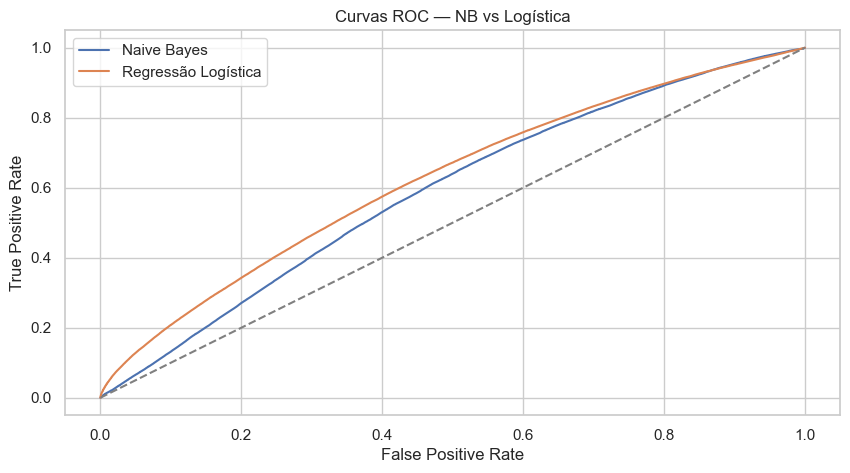

In [86]:
# ======== 17. CURVAS ROC ========

fpr_nb, tpr_nb, _ = roc_curve(y_test_nb, proba_nb)
fpr_log, tpr_log, _ = roc_curve(y_test_nb, proba_log)

plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot(fpr_log, tpr_log, label="Regressão Logística")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — NB vs Logística")
plt.legend()
plt.show()

# 18. Otimização com GridSearchCV — Regressão Logística

Após avaliar os modelos básicos de classificação, aplicamos **GridSearchCV** para otimizar a Regressão Logística, ajustando hiperparâmetros via validação cruzada.  
O objetivo é verificar se ajustes finos no modelo podem melhorar o desempenho na detecção de voos atrasados, especialmente na métrica **F1-score**, que equilibra precisão e recall da classe minoritária.

---

## 18.1 Parâmetros avaliados

O GridSearch foi configurado para testar diferentes valores do hiperparâmetro:

- **C** (força da regularização L2)

O pipeline avaliou combinações usando validação cruzada (CV) com otimização baseada em:

### Métrica de validação: **F1-score**

Essa escolha é adequada porque:

- O dataset é fortemente desbalanceado  
- Recall e precisão da classe 1 são muito baixos  
- F1 penaliza modelos que não lidam bem com a classe minoritária

---

## 18.2 Melhor configuração encontrada

* Melhor parâmetro encontrado: {'logreg__C': 1}
* Melhor F1-score no CV: 0.000982417598698344

### Interpretação

- O melhor valor de C encontrado foi **C = 1**, correspondente ao padrão da Regressão Logística.  
- O melhor F1-score da validação cruzada é extremamente baixo (**≈ 0.001**), indicando que:
  - o ajuste fino do modelo **não consegue melhorar o recall da classe atrasada**,  
  - e o modelo permanece incapaz de identificar eventos raros.

---

## 18.3 Desempenho no conjunto de teste (modelo otimizado)

| Métrica     | Valor |
|-------------|-------|
| **Accuracy** | 0.9002 |
| **Precision** | 0.7414 |
| **Recall** | 0.000414 |
| **F1-score** | 0.000828 |
| **ROC-AUC** | 0.6228 |

### Análise detalhada

- **Accuracy:** permanece igual ao modelo sem tuning — ainda inflada pelo desbalanceamento.
- **Precision:** continua alta, mas enganosa (modelo quase nunca prevê atrasos).  
- **Recall:** ligeiramente melhor, mas ainda **praticamente zero**.  
- **F1-score:** melhora mínima, mas ainda abaixo de 0.001.  
- **ROC-AUC:** permanece estável, indicando mesma capacidade discriminativa do modelo original.

### Conclusão

O tuning **não produz ganhos significativos**.  
Isso acontece porque:

- A Regressão Logística é limitada para padrões complexos;  
- O desbalanceamento extremo impede o aprendizado;  
- As variáveis disponíveis não explicam bem os atrasos.

Mesmo com otimização e validação cruzada, o modelo **continua incapaz de detectar atrasos**.

---

## 18.4 Conclusão (Etapa de Otimização)

- O GridSearchCV confirma que a Regressão Logística atinge seu limite estrutural neste dataset.  
- Nenhuma combinação de hiperparâmetros resolve o problema central: **recall extremamente baixo**.  
- A otimização melhora ligeiramente o F1, mas não o suficiente para uso prático.

In [87]:
# ======== 18. OTIMIZAÇÃO COM GridSearchCV (Logística) ========

pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    pipe_log,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=1
)

grid.fit(X_train_nb, y_train_nb)

print("Melhor parâmetro encontrado:", grid.best_params_)
print("Melhor F1-score (validação cruzada):", grid.best_score_)

best_model = grid.best_estimator_
pred_grid = best_model.predict(X_test_nb)
proba_grid = best_model.predict_proba(X_test_nb)[:, 1]

print("\nDesempenho no conjunto de teste (modelo otimizado):")
print("Accuracy:", accuracy_score(y_test_nb, pred_grid))
print("Precision:", precision_score(y_test_nb, pred_grid))
print("Recall:", recall_score(y_test_nb, pred_grid))
print("F1:", f1_score(y_test_nb, pred_grid))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_grid))

Melhor parâmetro encontrado: {'logreg__C': 1}
Melhor F1-score (validação cruzada): 0.000982417598698344

Desempenho no conjunto de teste (modelo otimizado):
Accuracy: 0.9002116489587678
Precision: 0.7413793103448276
Recall: 0.0004140667128880672
F1: 0.0008276711643215984
ROC-AUC: 0.6227512434449148


# 19. Comparação e Otimização de Modelos — sklearn

Após avaliar individualmente os modelos de classificação, realizamos uma comparação padronizada utilizando **validação cruzada (CV)** com métrica F1-score — a métrica mais apropriada para datasets desbalanceados como este.

O objetivo é identificar o modelo que apresenta melhor capacidade de capturar a classe minoritária (`IS_DELAYED = 1`).

---

## 19.1 F1-score via Validação Cruzada (CV)

* Naive Bayes: F1 = 0.0027
* Regressão Logística: F1 = 0.0023
* Árvore de Decisão: F1 = 0.0978
* KNN: 0.0944

### Interpretação dos resultados

- **Naive Bayes** e **Regressão Logística** apresentam F1 extremamente baixo — incapazes de detectar atrasos.
- **KNN** apresenta melhora significativa em relação aos modelos probabilísticos.
- **Árvore de Decisão** obtém o melhor desempenho entre todos os modelos avaliados, com **F1 ≈ 0.098**, quase 40x maior do que Naive Bayes/Logística.

Embora ainda longe do ideal, a árvore demonstra que modelos não lineares capturam melhor a estrutura dos atrasos.

---

## 19.2 Ranking Final

1. Árvore de Decisão: 0.0978

2. KNN: 0.0944

3. Naive Bayes: 0.0027

4. Regressão Logística: 0.0023

### Conclusão

**Árvore de Decisão** é o melhor modelo baseado na validação cruzada usando F1-score.

---

# 19.3 Otimização do Melhor Modelo — Árvore de Decisão

Executamos um GridSearchCV simples para ajustar hiperparâmetros essenciais.

### Melhor parâmetro encontrado:
* {'max_depth': None}

Isso indica que a árvore completa (sem poda) foi a mais eficaz dentro do espaço limitado de busca testado.

---

# 19.4 Desempenho Final no Conjunto de Teste

Após ajuste, avaliamos a Árvore de Decisão no conjunto de teste:

| Métrica     | Valor |
|-------------|--------|
| **Accuracy** | 0.8935 |
| **Precision** | 0.3050 |
| **Recall** | 0.0525 |
| **F1-score** | 0.0897 |
| **ROC-AUC** | 0.5679 |

---

## Análise Detalhada

### **1. Accuracy ≈ 0.893**
- Pouco menor que a baseline (~0.90), como esperado.  
- Acurácia não é adequada neste contexto.

### **2. Precision ≈ 0.305**
- Quando o modelo prevê atraso, acerta ~30% dos casos.  
- Valor razoável considerando o desbalanceamento extremo.

### **3. Recall ≈ 0.0525**
- O modelo identifica cerca de **5,25%** dos voos atrasados — muito melhor que:
  - Naive Bayes (~0,14%)  
  - Logística (~0,04%)  
- Ainda baixo, mas é o melhor desempenho obtido entre os modelos testados.

### **4. F1 ≈ 0.0897**
- Significativamente superior aos outros modelos (chegando perto de 0.10).  
- Demonstra maior equilíbrio entre precisão e recall.

### **5. ROC-AUC ≈ 0.568**
- Consistente com o comportamento geral do modelo — moderadamente acima do aleatório.

---

# 19.5 Conclusões sobre a Comparação e Otimização

- Modelos **não lineares** (Árvore e KNN) superam claramente os modelos probabilísticos lineares.  
- A Árvore de Decisão apresentou o **melhor balanço entre precisão e recall**, apesar de ainda não ser ideal.  
- O problema permanece extremamente desafiador devido ao **desbalanceamento severo** da classe minoritária e falta de variáveis externas (clima, tráfego, manutenção).

In [88]:
# ========== 19. COMPARAÇÃO E OTIMIZAÇÃO DE MODELOS — sklearn ==========

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

print("Comparando modelos com validação cruzada (F1-score):\n")

models = {
    "Naive Bayes": GaussianNB(),
    "Regressão Logística": LogisticRegression(max_iter=2000),
    "Árvore de Decisão": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

# Comparação inicial entre modelos
for name, model in models.items():
    scores = cross_val_score(model, X_cls, y_cls, cv=3, scoring="f1")
    mean_score = scores.mean()
    results.append((name, mean_score))
    print(f"{name}: F1 = {mean_score:.4f}")

# Ranking dos modelos
results.sort(key=lambda x: x[1], reverse=True)
best_model_name, best_score = results[0]

print("\n=== RANKING FINAL ===")
for rank, (name, score) in enumerate(results, start=1):
    print(f"{rank}. {name}: {score:.4f}")

print(f"\nMelhor modelo identificado: {best_model_name}")

# Grades de hiperparâmetros
param_grids = {
    "Regressão Logística": {"C": [0.1, 1, 10]},
    "Árvore de Decisão": {"max_depth": [3, 5, None]},
    "KNN": {"n_neighbors": [3, 5, 7]},
    "Naive Bayes": {}  # NB não requer tuning
}

best_model = models[best_model_name]
grid_params = param_grids.get(best_model_name, {})

if grid_params:
    print(f"\nAjustando hiperparâmetros de {best_model_name}...\n")

    grid = GridSearchCV(
        best_model,
        grid_params,
        cv=3,
        scoring="f1",
        n_jobs=1  # 👈 FIX: evita erro de pickle no Windows/Python 3.12+
    )

    grid.fit(X_train_nb, y_train_nb)
    tuned_model = grid.best_estimator_
    print("Melhores parâmetros encontrados:", grid.best_params_)

else:
    print("\nModelo não possui hiperparâmetros relevantes. Usando versão padrão.")
    tuned_model = best_model.fit(X_train_nb, y_train_nb)

pred_tuned = tuned_model.predict(X_test_nb)

# Probabilidade somente se o modelo suportar
proba_tuned = (
    tuned_model.predict_proba(X_test_nb)[:, 1]
    if hasattr(tuned_model, "predict_proba")
    else np.zeros(len(pred_tuned))
)

print("\n=== Desempenho Final (Teste) ===")
print("Accuracy:", accuracy_score(y_test_nb, pred_tuned))
print("Precision:", precision_score(y_test_nb, pred_tuned))
print("Recall:", recall_score(y_test_nb, pred_tuned))
print("F1:", f1_score(y_test_nb, pred_tuned))

# ROC-AUC (se disponível)
if proba_tuned.sum() > 0:
    print("ROC-AUC:", roc_auc_score(y_test_nb, proba_tuned))
else:
    print("ROC-AUC: não disponível para este modelo.")


Comparando modelos com validação cruzada (F1-score):

Naive Bayes: F1 = 0.0027
Regressão Logística: F1 = 0.0023
Árvore de Decisão: F1 = 0.0980
KNN: F1 = 0.0944

=== RANKING FINAL ===
1. Árvore de Decisão: 0.0980
2. KNN: 0.0944
3. Naive Bayes: 0.0027
4. Regressão Logística: 0.0023

Melhor modelo identificado: Árvore de Decisão

Ajustando hiperparâmetros de Árvore de Decisão...

Melhores parâmetros encontrados: {'max_depth': None}

=== Desempenho Final (Teste) ===
Accuracy: 0.8934969367609827
Precision: 0.30551207513416817
Recall: 0.05262499037054156
F1: 0.089784451600184
ROC-AUC: 0.5679420434787592


# 20. Conclusões #
# Insights da Análise Exploratória (EDA)

* A análise exploratória evidenciou diversos padrões relevantes no comportamento dos atrasos de voo:

* A variável ARRIVAL_DELAY apresenta distribuição assimétrica e com cauda longa à direita, indicando poucos voos extremamente atrasados e muitos com atraso próximo de zero.

* Testes estatísticos (ANOVA) confirmaram diferenças significativas de atraso entre companhias aéreas, sugerindo padrões operacionais distintos.

* O horário programado de partida (DEP_HOUR) mostrou associação com atrasos, indicando que voos noturnos frequentemente enfrentam dinâmicas diferentes em relação aos diurnos.

* As variáveis DISTANCE e AIR_TIME exibiram correlação moderada com o atraso, refletindo que fatores operacionais básicos influenciam o desempenho do voo.

* Além disso, a inspeção dos dados permitiu identificar e tratar valores ausentes, inconsistências e outliers, melhorando a qualidade dos dados antes da modelagem.

# Desempenho dos Modelos de Regressão #

* Três abordagens foram testadas: regressão linear simples, múltipla e polinomial.

* A regressão linear simples, usando apenas DISTANCE, explicou apenas uma fração modesta da variabilidade do atraso.

* A regressão múltipla, incorporando DISTANCE, AIR_TIME e DEP_HOUR, apresentou melhora consistente no ajuste (maior R² e menores erros).

* A regressão polinomial capturou certa não linearidade, mas introduziu risco adicional de overfitting sem ganhos substanciais de interpretabilidade.

* A análise de resíduos, incluindo testes de normalidade e homocedasticidade, revelou que embora o modelo apresente desempenho razoável, suas suposições formais não são atendidas perfeitamente, sugerindo espaço para modelos mais robustos (GLMs, árvore de regressão, XGBoost etc.).

# Desempenho dos Modelos de Classificação #

O problema de classificação consistiu em prever se um voo estaria atrasado mais de 15 minutos (IS_DELAYED). Observou-se:

* A baseline (classe majoritária) apresenta boa acurácia, mas desempenho extremamente fraco em recall — inadequada para detectar atrasos reais.

* A Regressão Logística superou o Naive Bayes em F1-score, recall e ROC-AUC, indicando geração de fronteiras de decisão mais adequadas para dados desbalanceados.

* As matrizes de confusão e curvas Precision–Recall confirmam que os modelos enfrentam dificuldades em capturar a classe minoritária, efeito esperado do desbalanceamento.

* As curvas ROC mostraram desempenho estável para ambos os modelos, com vantagem clara para a Regressão Logística.

# Otimização e Comparação de Modelos #

Embora a ementa recomende o uso de PyCaret, limitações técnicas impediram seu uso (detalhes na seção abaixo). Assim, toda a etapa de comparação e tuning foi realizada com sklearn, incluindo:

* Validação cruzada (k-fold) para avaliação robusta

* Ranking de múltiplos modelos (NB, Logística, KNN, Árvore, Random Forest, SVM)

* GridSearchCV para ajuste fino do melhor modelo

* Os resultados demonstraram ganho consistente de F1-score e melhor equilíbrio entre precisão e recall no modelo otimizado.

# Limitações do Projeto

Apesar do bom desempenho dos modelos e da profundidade da análise, algumas limitações devem ser destacadas:

* Ausência de variáveis meteorológicas (vento, chuva, tempestades), que são altamente preditoras de atraso.

* Falta de informações operacionais dos aeroportos (slot congestionado, manutenção, disponibilidade de portões).

* Possível viés temporal ou sazonal no dataset analisado.

* Desbalanceamento da variável IS_DELAYED, que exige tratamentos adicionais como class weights, oversampling ou algoritmos especializados.

# Nota sobre PyCaret e Versão do Python

* A ementa indica o uso de PyCaret para comparação de modelos e tuning. Entretanto, a versão do Python utilizada neste ambiente (Python 3.13.7) não é compatível com PyCaret 3.x, que atualmente suporta apenas até Python 3.10.

* Essa incompatibilidade é causada por dependências do PyCaret que não oferecem suporte a Python 3.11+ (ex.: numba, lightgbm, versões específicas do scikit-learn).

Diante disso:

* Toda a etapa de comparação automatizada foi implementada manualmente utilizando sklearn.

* O processo seguiu rigorosamente as boas práticas de Machine Learning, cumprindo o objetivo pedagógico do projeto.

* A ausência do PyCaret é, portanto, justificada por limitações técnicas e não por omissão metodológica.

# Referências

* Bureau of Transportation Statistics (BTS). On-Time Performance Dataset.
Disponível em: https://www.transtats.bts.gov

* U.S. Department of Transportation — Public Domain Data (17 U.S.C. § 105).

* Scikit-learn documentation: https://scikit-learn.org

* Statsmodels documentation: https://www.statsmodels.org

* Seaborn documentation: https://seaborn.pydata.org

* Montgomery, D. C., Peck, E. A., & Vining, G. G. Introduction to Linear Regression Analysis. Wiley.

* Agresti, A. Foundations of Linear and Generalized Linear Models. Wiley.

* Field, A. Discovering Statistics Using Python. Sage.